In [ ]:

import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import scipy
from network2tikz import plot
import pyamg
import cnet
from sklearn.cluster import SpectralClustering   
import heapq
from heapq import heappush, heappop
from itertools import count
from cnet import logger, Network, Path, Paths, Edge
from cnet.utils.exceptions import CnetError, CnetNotImplemented
from scipy.sparse import csgraph, find, isspmatrix, csr_matrix
from cnet.algorithms.diffusion import RandomWalkDiffusion
from scipy import sparse
from scipy.sparse import coo_matrix
import time
from cnet.algorithms.traffic_assignment import msa, msa_fast
from cnet.classes.road_network import RoadNetwork
import timeit
import copy
from cnet.algorithms.markov import cost_matrix, estimate_transition_matrix
import pandas as pd
from collections import defaultdict
from copy import deepcopy
from cnet.algorithms.shortest_path import (shortest_path, _shortest_path, dijkstra)
import seaborn as sn
import matplotlib.pyplot as plt 




In [ ]:

def msa(network, od_flow, limit=0.5, max_iter=float('inf'), enable_paths=True):


    # initialze variables
    origins = list(od_flow)
    destinations = list(set(n for k, v in od_flow.items() for n in v))
    od_paths = defaultdict(dict)

    # create empty dict with edges as keys
    empty = {e: 0 for e in network.edges}

    # initialize variables
    volume = deepcopy(empty)
    potential_volume = deepcopy(empty)
    n2e = network.nodes_to_edges_map()

    # initial all-or-nothing assignment
    for o in origins:
        for d in destinations:
            cost, path = dijkstra(network, o, d)
            edges = [n2e[path[i], path[i+1]][0] for i in range(len(path)-1)]
            for e in edges:
                potential_volume[e] += od_flow[o][d]

    # algorithm
    volume = deepcopy(potential_volume)
    potential_volume = deepcopy(empty)
    temp_volume = deepcopy(empty)
    n = 1

    if enable_paths:
        temp_path_list = []

    while calculate_limit(volume, temp_volume) > limit:
        #n += 1
        # update_volume(volume)
        for e, E in network.edges.items():
            E.volume = volume[e]

        temp_volume = deepcopy(volume)

        if enable_paths:
            temp_paths = {}

        for o in origins:
            for d in destinations:
                cost, path = dijkstra(network, o, d)
                edges = [n2e[path[i], path[i+1]][0]
                         for i in range(len(path)-1)]

                if enable_paths:
                    temp_paths[tuple(path)] = od_flow[o][d]
                    od_paths[(o, d)][tuple(path)] = 0

                for e in edges:
                    potential_volume[e] += od_flow[o][d]

        for e in network.edges:
            volume[e] = (1-1/n) * volume[e] + 1/n * potential_volume[e]
        potential_volume = deepcopy(empty)

        if enable_paths:
            for path, value in temp_paths.items():
                temp_path_list.append([n, path, value * 1/n])

        if n >= max_iter:
            log.warn("Maximum number ({}) of iterations was reached!".format(n))
            break
        n += 1

    if enable_paths:
        temp_path_list.sort(key=lambda x: x[0], reverse=True)
        for n, path, flow in temp_path_list:
            o = path[0]
            d = path[-1]

            if sum(od_paths[(o, d)].values()) <= od_flow[o][d]:
                od_paths[(o, d)][path] += flow

        P = Paths()
        for od, paths in od_paths.items():
            for path, flow in paths.items():
                if flow > 0:
                    p = Path(flow=flow)
                    _cost = 0
                    _weight = 0
                    _fft = 0
                    for i in range(len(path)-1):
                        e = network.edges[(path[i], path[i+1])]
                        p.add_edge(e)
                        _weight += e.cost
                        _cost += e.cost * flow / e.volume
                        _fft += e.free_flow_time
                    p['cost'] = _cost
                    p['weight'] = _weight
                    p['fft'] = _fft
                    P.add_path(p)

    if enable_paths:
        return P
    else:
        return None


# def msa(network, od_flow, limit=0.5, max_iter=float('inf'), enable_paths=True):
#     # initialze variables
#     origins = list(od_flow)
#     destinations = list(set(n for k, v in od_flow.items() for n in v))
#     od_paths = defaultdict(dict)

#     # create empty dict with edges as keys
#     empty = {e: 0 for e in network.edges}

#     # initialize variables
#     volume = deepcopy(empty)
#     potential_volume = deepcopy(empty)
#     n2e = network.nodes_to_edges_map()

#     # initial all-or-nothing assignment
#     for o in origins:
#         for d in destinations:
#             path = shortest_path(network, o, d, weight='weight')
#             for e in path.edges:
#                 potential_volume[e] += od_flow[o][d]

#     # algorithm
#     volume = deepcopy(potential_volume)
#     potential_volume = deepcopy(empty)
#     temp_volume = deepcopy(empty)
#     n = 1

#     # if enable_paths:
#     #     temp_path_list = []

#     while calculate_limit(volume, temp_volume) > limit:
#         n += 1
#         update_volume(network, volume)
#         temp_volume = deepcopy(volume)

#         # if enable_paths:
#         #     temp_paths = {}

#         for o in origins:
#             for d in destinations:
#                 path = shortest_path(network, o, d, weight='weight')

#                 # if enable_paths:
#                 #     temp_paths[tuple(path)] = self.od_flow[o][d]
#                 #     self.od_paths[(o, d)][tuple(path)] = 0

#                 for e in path.edges:
#                     potential_volume[e] += od_flow[o][d]

#         for e in network.edges:
#             volume[e] = (1-1/n) * volume[e] + 1/n * potential_volume[e]
#         potential_volume = deepcopy(empty)

#         # if enable_paths:
#         #     for path, value in temp_paths.items():
#         #         temp_path_list.append([n, path, value * 1/n])

#         if n >= max_iter:
#             log.warn("Maximum number ({}) of iterations was reached!".format(n))
#             break

#     # if enable_paths:
#     #     temp_path_list.sort(key=lambda x: x[0], reverse=True)
#     #     for n, path, flow in temp_path_list:
#     #         o = path[0]
#     #         d = path[-1]
#     #         if sum(self.od_paths[(o, d)].values()) <= self.od_flow[o][d]:
#     #             self.od_paths[(o, d)][path] += flow

#     # update the network
#     for e, vol in volume.items():
#         network.edges[e].volume = vol
#         w = network.edges[e].weight()

#     pass


def update_volume(network, volume):
    for e, E in network.edges.items():
        E.volume = volume[e]


def calculate_limit(prior, posterior):
    limiter = 0
    for l in prior:
        limiter += abs(prior[l]-posterior[l])
    return limiter

In [ ]:



def msa_one( layer_one,network, od_flow,layer_two, layer_three, partition, limit=0.5, max_iter=float('inf'), enable_paths=True):
    # initialze variables
    origins = list(od_flow)
    #print("origins", origins)
    destinations = list(set(n for k, v in od_flow.items() for n in v))
    #print("destinations : ", destinations)
    od_paths = defaultdict(dict)

    # create empty dict with edges as keys
    empty = {e: 0 for e in network.edges}

    # initialize variables
    volume = deepcopy(empty)
    potential_volume = deepcopy(empty)
    n2e = network.nodes_to_edges_map()  
    # initial all-or-nothing assignment
    for o in origins:
        for d in destinations:
            if(o!=d):    
                path = list(layer_three.paths)[0][(o,d)][0]
                #print("the path from msa :", path)
                edges = [n2e[path[1][i], path[1][i+1]][0] for i in range(len(path[1])-1)]
                for e in edges:
                    potential_volume[e] += od_flow[o][d]

    # algorithm
    volume = deepcopy(potential_volume)
    potential_volume = deepcopy(empty)
    temp_volume = deepcopy(empty)
    n = 1

    if enable_paths:
        temp_path_list = []

    while calculate_limit(volume, temp_volume) > limit:
        #n += 1
        # update_volume(volume)
        for e, E in network.edges.items():
            E.volume = volume[e]

        temp_volume = deepcopy(volume)

        if enable_paths:
            temp_paths = {}

        for o in origins:
            for d in destinations:
                if(o != d):
                    path = list(layer_three.paths)[0][(o,d)][0]   #############*****************
                    edges = [n2e[path[1][i], path[1][i+1]][0] for i in range(len(path[1])-1)] #############*****************
                    if enable_paths:
                        temp_paths[tuple(path[1])] = od_flow[o][d]    #############*****************
                        od_paths[(o, d)][tuple(path[1])] = 0    #############*****************
                        #print("path : ", path, "flow : ", od_flow[o][d])
                    for e in edges:
                        potential_volume[e] += od_flow[o][d]

        for e in network.edges:
            volume[e] = (1-1/n) * volume[e] + 1/n * potential_volume[e]
        potential_volume = deepcopy(empty)

        if enable_paths:
            for path, value in temp_paths.items():
                temp_path_list.append([n, path, value * 1/n])

        if n >= max_iter:
            log.warn("Maximum number ({}) of iterations was reached!".format(n))
            break
        n += 1

    if enable_paths:
        temp_path_list.sort(key=lambda x: x[0], reverse=True)
        for n, path, flow in temp_path_list:
            o = path[0]
            d = path[-1]

            if sum(od_paths[(o, d)].values()) <= od_flow[o][d]:
                od_paths[(o, d)][path] += flow

        P = Paths()
        for od, paths in od_paths.items():
            for path, flow in paths.items():
                #print("the path : ", path, " :: and the flow : ", flow)
                if flow > 0:
                    p = Path(flow=flow)
                    _cost = 0
                    _weight = 0
                    _fft = 0
                    #i=0
                    for i in range(len(path)-1):
                     #   i=i+1
                        e = network.edges[(path[i], path[i+1])]
                        p.add_edge(e)
                        _weight += e.cost
                        _cost += e.cost * flow / e.volume
                        _fft += e.free_flow_time
                    #print("i")
                    p['cost'] = _cost
                    p['weight'] = _weight
                    p['fft'] = _fft
                    P.add_path(p)
                    #print('THis should be 552')
        
        #for i in P:
            #print(i.path)
    if enable_paths:
        return P
    else:
        return None


def update_volume(network, volume):
    for e, E in network.edges.items():
        E.volume = volume[e]


def calculate_limit(prior, posterior):
    limiter = 0
    for l in prior:
        limiter += abs(prior[l]-posterior[l])
    return limiter

In [ ]:

def msa_original(edge_removed,layer_one, network, od_flow,layer_two, layer_three, partition, limit=0.5, max_iter=float('inf'), enable_paths=True, mode='default'): 
    origins = list(set(i for i in list(od_flow) if i in partition)) 
    
    destinations = list(set(n for k, v in od_flow.items() for n in v if n in partition)) 
    od_paths = defaultdict(dict)
    
    empty = {e: 0 for e in network.edges}  

    volume = deepcopy(empty)
    potential_volume = deepcopy(empty)
    n2e = layer_one.getNetwork().nodes_to_edges_map()
    
    final_dict= defaultdict(dict) #### okay, keep going
    
    for o in origins:
        for d in destinations:
            if( o != d):
                paths = list(layer_three.paths)[0][(o,d)]                  
                new_paths = list()
                for x,y in enumerate(paths):
                    edges=[]
                    for i in range(len(paths[x][1])-1):
                        edges.append(n2e[paths[x][1][i], paths[x][1][i+1]][0])
                    #edges  = [n2e[paths[x][1][i], paths[x][1][i+1]][0] for i in range(len(paths[x][1])-1)] 
                        #if edge_removed not in edges:
                        #    new_paths.append((paths[x][1]))                
                        if mode == 'removed':   
                            if edge_removed not in edges:
                                new_paths.append(paths[x])
                        elif mode == 'not_removed':
                            new_paths.append(paths[x])  
                        

                    
                #new_edges  = [n2e[new_paths[0][i], new_paths[0][i+1]][0] for i in range(len(new_paths[0])-2)] 
                #new_edges  = [n2e[new_paths[0][1][i], new_paths[0][1][i+1]][0] for i in range(len(paths[0][1])-1)]
                #print("new_edges : ", new_edges)
                new_edges = []
                for x,path in enumerate(new_paths):
                    for i in range(len(path[1])-1):
                        new_edges.append(n2e[path[1][i] , path[1][i+1]][0])
                    edges = [i for i in new_edges]
                #print("edges : ", edges)
                #print("potential_volume : ", potential_volume)
                    for e in edges:
                        potential_volume[e] += od_flow[o][d]

    # algorithm
    volume = deepcopy(potential_volume)
    potential_volume = deepcopy(empty)
    temp_volume = deepcopy(empty)
    n = 1

    if enable_paths:
        temp_path_list = []

    while calculate_limit_one(volume, temp_volume) > limit:
        #n += 1
        # update_volume(volume)
        for e, E in network.edges.items():
            E.volume = volume[e]
#E.volume .... confused with this
        temp_volume = deepcopy(volume)

        if enable_paths:
            temp_paths = {}

        for o in origins:
            for d in destinations:
                if(o != d):
                    paths = list(layer_three.paths)[0][(o,d)]     
                    new_paths = list()
                    for x,y in enumerate(paths):
                        edges=[]
                        for i in range(len(paths[x][1])-1):
                            edges.append(n2e[paths[x][1][i], paths[x][1][i+1]][0])
                                 
                        if mode == 'removed':   
                            if edge_removed not in edges:
                                new_paths.append(paths[x])
                        elif mode == 'not_removed':
                            new_paths.append(paths[x])                     
                    ################################################### ###################################################
                    new_edges = []
                    for x,path in enumerate(new_paths):
                        for i in range(len(path[1])-1):
                            new_edges.append(n2e[path[1][i] , path[1][i+1]][0])
                        edges = [i for i in new_edges]
                    #print("edges : ", edges)
                    #print("potential_volume : ", potential_volume)
                        for e in edges:
                            potential_volume[e] += od_flow[o][d]
                    ################################################### ###################################################
                    if enable_paths:
                        for x, path in enumerate(new_paths):
                            temp_paths[tuple(new_paths[x][1])] = od_flow[o][d]
                        for i,j  in enumerate(new_paths):
                            od_paths[(o, d)][tuple(new_paths[i][1])] = 0

        for e in network.edges: 
            volume[e] = (1-1/n) * volume[e] + 1/n * potential_volume[e]
        potential_volume = deepcopy(empty)

        if enable_paths:
            for path, value in temp_paths.items():
                temp_path_list.append([n, path, value * 1/n])

        if n >= max_iter:
            log.warn("Maximum number ({}) of iterations was reached!".format(n))
            break
        n += 1

    if enable_paths:
        temp_path_list.sort(key=lambda x: x[0], reverse=True)
        for n, path, flow in temp_path_list:
            o = path[0]
            d = path[-1]

            if sum(od_paths[(o, d)].values()) <= od_flow[o][d]:  
                for i in od_paths[(o,d)].items():
                    #for x in i.items():
                        od_paths[(o, d)][i[0]] += flow
  #compute the toal cost directly inside the msa      
        P = Paths()
        for od, paths in od_paths.items():
            for path, flow in paths.items():
                path_edge_list = list()  #just now added ,,, tupled list
                if flow > 0:
                    p = Path(flow=flow)
                    _cost = 0
                    _weight = 0
                    _fft = 0
                    for i in range(len(path)-1):
                        e = network.edges[(path[i], path[i+1])]
                        p.add_edge(e)
                        _weight += e.cost
                        _cost += e.cost * flow / e.volume
                        _fft += e.free_flow_time
                        path_edge_list.append(()) ####
                    
                    #final_dict[od].append(p, flow)
                    p['cost'] = _cost
                    p['weight'] = _weight
                    p['fft'] = _fft
                    #final_dict[od].append(p)
                    final_dict[od][path]= [flow, _weight, _cost, _fft]
                    #final_dict[od].append((path ,flow, _weight, _cost, _fft))
                    P.add_path(p)

    if enable_paths:
        return P, final_dict
    else:
        return None

In [ ]:
#Modified MSA that computes total edge flow(volume) for all 5 shortest paths
#Benefits: one can get a better idea of the overall edges. Instead of using only the first shortest path for the volume calculation, it uses all 5 shortest paths. 
#Offsets the paths values but at same time it gives better estimate for edges that are more important. However it can bring out unwanted edges that wouldnt get added in the normal MSA. Tradeoff Is something to analyze!
def msa_modified_second(edge_removed,layer_one, network, od_flow,layer_two, layer_three, partition, limit=0.5, max_iter=float('inf'), enable_paths=True, mode='default'): 
    origins = list(set(i for i in list(od_flow) if i in partition)) 
    
    destinations = list(set(n for k, v in od_flow.items() for n in v if n in partition)) 
    od_paths = defaultdict(dict)
    
    empty = {e: 0 for e in network.edges}  

    volume = deepcopy(empty)
    potential_volume = deepcopy(empty)
    n2e = layer_one.getNetwork().nodes_to_edges_map()
    final_dict= defaultdict(dict) #### okay, keep going
    for o in origins:
        for d in destinations:
            if( o != d):
                paths = list(layer_three.paths)[0][(o,d)]                  
                new_paths = list()
                for x,y in enumerate(paths):
                    edges=[]
                    for i in range(len(paths[x][1])-1):
                        edges.append(n2e[paths[x][1][i], paths[x][1][i+1]][0])
                    
                    if mode == 'removed':   
                        if edge_removed not in edges:
                            new_paths.append(paths[x])
                    elif mode == 'not_removed':
                        new_paths.append(paths[x])                        

                new_edges = []
                for x,path in enumerate(new_paths):
                    for i in range(len(path[1])-1):
                        new_edges.append(n2e[path[1][i] , path[1][i+1]][0])
                    edges = [i for i in new_edges]
                    for e in edges:
                        potential_volume[e] += od_flow[o][d]

    # algorithm
    volume = deepcopy(potential_volume)
    potential_volume = deepcopy(empty)
    temp_volume = deepcopy(empty)
    n = 1

    if enable_paths:
        temp_path_list = []

    while calculate_limit_one(volume, temp_volume) > limit:
        #n += 1
        # update_volume(volume)
        for e, E in network.edges.items():
            E.volume = volume[e]
#E.volume .... confused with this
        temp_volume = deepcopy(volume)

        if enable_paths:
            temp_paths = {}

        for o in origins:
            for d in destinations:
                if(o != d):
                    paths = list(layer_three.paths)[0][(o,d)]     
                    new_paths = list()
                    for x,y in enumerate(paths):
                        edges=[]
                        for i in range(len(paths[x][1])-1):
                            edges.append(n2e[paths[x][1][i], paths[x][1][i+1]][0])
                            new_paths.append((paths[x]))
                        if mode == 'removed':   
                            if edge_removed not in edges:
                                new_paths.append(paths[x])
                        elif mode == 'not_removed':
                            new_paths.append(paths[x])           
                      
                    ################################################### ###################################################
                    new_edges = []
                    for x,path in enumerate(new_paths):
                        for i in range(len(path[1])-1):
                            new_edges.append(n2e[path[1][i] , path[1][i+1]][0])
                        edges = [i for i in new_edges]
                    #print("edges : ", edges)
                    #print("potential_volume : ", potential_volume)
                        for e in edges:
                            potential_volume[e] += od_flow[o][d]
                    ################################################### ###################################################
                    if enable_paths:
                        for x, path in enumerate(new_paths):
                            temp_paths[tuple(new_paths[x][1])] = od_flow[o][d]
                        for i,j  in enumerate(new_paths):
                            od_paths[(o, d)][tuple(new_paths[i][1])] = 0

        for e in network.edges: 
            volume[e] = (1-1/n) * volume[e] + 1/n * potential_volume[e]
        potential_volume = deepcopy(empty)

        if enable_paths:
            for path, value in temp_paths.items():
                temp_path_list.append([n, path, value * 1/n])

        if n >= max_iter:
            log.warn("Maximum number ({}) of iterations was reached!".format(n))
            break
        n += 1

    if enable_paths:
        temp_path_list.sort(key=lambda x: x[0], reverse=True)
        for n, path, flow in temp_path_list:
            o = path[0]
            d = path[-1]

            if sum(od_paths[(o, d)].values()) <= od_flow[o][d]:  
                for i in od_paths[(o,d)].items():
                    #for x in i.items():
                        od_paths[(o, d)][i[0]] += flow
        
        P = Paths()
        for od, paths in od_paths.items():
            for path, flow in paths.items():
                if flow > 0:
                    p = Path(flow=flow)
                    _cost = 0
                    _weight = 0
                    _fft = 0
                    for i in range(len(path)-1):
                        e = network.edges[(path[i], path[i+1])]
                        p.add_edge(e)
                        _weight += e.cost
                        _cost += e.cost * flow / e.volume
                        _fft += e.free_flow_time
                    
                    #final_dict[od].append(p, flow)
                    p['cost'] = _cost
                    p['weight'] = _weight
                    p['fft'] = _fft
                    #final_dict[od].append(p)
                    final_dict[od][path]= [flow, _weight, _cost, _fft]
                    #final_dict[od].append((path ,flow, _weight, _cost, _fft))
                    P.add_path(p)

    if enable_paths:
        return P, final_dict
    else:
        return None

In [ ]:
#Orignal MSA except with a tweak. 
#The calculated volume is the same. But paths 2,3,4, and 5 are added into the od_paths dictioanry
#the reason this is fruitful. Is because you can now see how each path would interact with UE environment. This is becuase when compared to the greedy approach of only calculating the volume for the first shortest path of each od
# yoou can start to see how the paths play out in that network.
#For each distribution of the network (the paths being analyzed): you will have new paths that will take on better volume and costs. These new paths are great alternatives for the current traffic scenario.
#Also, adding the five paths is extremely beneficial for optimzation tasks. 
        #1) I could implement today: Do a hard search over all possible paths for every od: Which ever combination leads to lowest volume and cost for overall network is the winning distirubiton of paths
        #2) Have to study more on trans and stat but: This MSA for the first shortest allows the paths not being used to be truly evaluated in layer 4. the trans and stat could give better idea of what path works best in this distribution. 
            #Therefore, we could use the layer 4 to tell us what path is most optimal (I.E what is trans saying is most probable? (But WHY?))
            #Then we create and new paths dictionary from layer four. And pass this back to the MSA. Then the MSA recomputes the flows, then go to layer 4, and then see what new paths in that distribution is the most optimal. Then pass this back to the MSA and repeat
            #Repear this process while keeping track of the total  volume  and cost of each distribution. 
            #Then return the distribtuion with the lowest volume and cost (Or maybe we could return it on which distribution gives the most optimal trans or stat matrices... but this is difficult math)
            #This idea sounds good: But I have to understadn trans and stat better. ALso, it possible we might get stuck in local minimums. So I would have to adjust for this.....
def msa_modified(edge_removed,layer_one, network, od_flow,layer_two, layer_three, partition, limit=0.5, max_iter=float('inf'), enable_paths=True, mode= 'default'): #pass in layer 2 parition, matrix modes list, and adj matrix... also pass in layer_three paths
    #have to solve this problem with the edges.... like a boolean or soemthing to signify if an edge is being removed or not
    origins = list(set(i for i in list(od_flow) if i in partition)) 
    
    destinations = list(set(n for k, v in od_flow.items() for n in v if n in partition)) 
    od_paths = defaultdict(dict)
    
    empty = {e: 0 for e in network.edges}  

    volume = deepcopy(empty)
    potential_volume = deepcopy(empty)
    n2e = layer_one.getNetwork().nodes_to_edges_map()
    final_dict= defaultdict(dict) #### okay, keep going
    
    for o in origins:
        for d in destinations:
            if( o != d):
                paths = list(layer_three.paths)[0][(o,d)]                  
                new_paths = list()
                #for x,y in enumerate(paths):   # this is my modified. The next for loop is the original MSA
                for x,y in enumerate(paths[0]): # this would be the original msa
                    edges=[]
                    for i in range(len(paths[x][1])-1):
                        edges.append(n2e[paths[x][1][i], paths[x][1][i+1]][0])
                            
                    if mode == 'removed':   
                        if edge_removed not in edges:
                            new_paths.append(paths[x])
                    elif mode == 'not_removed':
                        new_paths.append(paths[x])
#######################################################################
    
                new_edges = []
                #print("new_paths[0] : ", new_paths)
                #print("new_paths[0][1] : ", new_paths[0] )
                #print("len(new_paths[0][1]) : ", len(new_paths[0][1]) )
                for i in range(len(new_paths[0][1])-1):
                    #print("i")
                    new_edges.append(n2e[new_paths[0][1][i] , new_paths[0][1][i+1]][0])
                edges = [i for i in new_edges]
        
                for e in edges:
                    potential_volume[e] += od_flow[o][d]

    # algorithm
    volume = deepcopy(potential_volume)
    potential_volume = deepcopy(empty)
    temp_volume = deepcopy(empty)
    n = 1

    if enable_paths:
        temp_path_list = []

    while calculate_limit_one(volume, temp_volume) > limit:
        #n += 1
        # update_volume(volume)
        for e, E in network.edges.items():
            E.volume = volume[e]
#E.volume .... confused with this
        temp_volume = deepcopy(volume)

        if enable_paths:
            temp_paths = {}

        for o in origins:
            for d in destinations:
                if(o != d):
                    paths = list(layer_three.paths)[0][(o,d)]     
                    new_paths = list()
                    #for x,y in enumerate(paths):   # this is my modified. The next for loop is the original MSA
                    for x,y in enumerate(paths[0]):    # this is the original msa
                        edges=[]
                        for i in range(len(paths[x][1])-1):
                            edges.append(n2e[paths[x][1][i], paths[x][1][i+1]][0])
                    
                        if mode == 'removed':   
                            if edge_removed not in edges:
                                new_paths.append(paths[x])
                        elif mode == 'not_removed':
                            new_paths.append(paths[x])     
                                                          
                    
                    new_edges =[]
                    for i in range(len(new_paths[0][1])-1):
                        
                        new_edges.append(n2e[new_paths[0][1][i], new_paths[0][1][i+1]][0])
                    
                    edges = [i for i in new_edges ]
                    for e in edges:
                        potential_volume[e] += od_flow[o][d]


                    if enable_paths:
                        #temp_paths[tuple(paths[0][1])] = od_flow[o][d] 
                        temp_paths[tuple(new_paths[0][1])] = od_flow[o][d]
                        for i,j  in enumerate(new_paths):
                            od_paths[(o, d)][tuple(new_paths[i][1])] = 0

        for e in network.edges: 
            volume[e] = (1-1/n) * volume[e] + 1/n * potential_volume[e]
        potential_volume = deepcopy(empty)

        if enable_paths:
            for path, value in temp_paths.items():
                temp_path_list.append([n, path, value * 1/n])

        if n >= max_iter:
            log.warn("Maximum number ({}) of iterations was reached!".format(n))
            break
        n += 1

    if enable_paths:
        temp_path_list.sort(key=lambda x: x[0], reverse=True)
        for n, path, flow in temp_path_list:
            o = path[0]
            d = path[-1]

            if sum(od_paths[(o, d)].values()) <= od_flow[o][d]:  #this part of code needs alot of thinkning and work...
                for i in od_paths[(o,d)].items():
                    #for x in i.items():
                        od_paths[(o, d)][i[0]] += flow
        
        #final_dict = defaultdict(dict)
        #final_dict = defaultdict(list)
        #final_dict = {}
        P = Paths()
        for od, paths in od_paths.items():
            for path, flow in paths.items():
                if flow > 0:
                    p = Path(flow=flow)
                    _cost = 0
                    _weight = 0
                    _fft = 0
                    for i in range(len(path)-1):
                        e = network.edges[(path[i], path[i+1])]
                        p.add_edge(e)
                        if e.volume == 0:   #logic is that the cost should be higher if volume is lower. So just give volume a vlaue of one so cost is cost times flow
                            e.volume =1     #this is because some of the edges have not had their volumes preset becuase they were not seen. A way of handling this in the future is to compute the volume of this path with its repspected 1st 2nd 3rd or 4th paths companions
                        _weight += e.cost
                        _cost += e.cost * flow / e.volume
                        _fft += e.free_flow_time
                    
                    #final_dict[od].append(p, flow)
                    p['cost'] = _cost
                    p['weight'] = _weight
                    p['fft'] = _fft
                    #final_dict[od].append(p)
                    final_dict[od][path]= [flow, _weight, _cost, _fft]
                    #final_dict[od].append([path ,flow, _weight, _cost, _fft])
                    P.add_path(p) 

    if enable_paths:
        return  P, final_dict
    else:
        return None

In [ ]:
    
def update_volume(network, volume):
    for e, E in network.edges.items():
        E.volume = volume[e]


def calculate_limit_one(prior, posterior):
    limiter = 0
    for l in prior:
        limiter += abs(prior[l]-posterior[l])
    return limiter

In [ ]:
def inertia(spectral_clustering):

     inertia = 0
     #loops through the amount of clusters dedpending on how many different labels (chosen from elbow method function)
     for cluster in np.unique(spectral_clustering.labels_): 
        #gets all points for that specific cluster that matches the specfic label
       list_of_indices = list(np.where(list(spectral_clustering.labels_) == cluster)[0]) 
       #create an adjacency matrix for the points in the cluster
       points_in_cluster = spectral_clustering.affinity_matrix_[list_of_indices,:]
       # then take the mean of that the cluster
       centroid = np.mean(points_in_cluster, axis=0)
       squared_distance = 0

       for data_point in points_in_cluster:
         squared_distance = squared_distance + (np.sqrt(np.sum((data_point- centroid)**2))) 
       inertia = inertia + squared_distance 

     return inertia 

In [ ]:


def dijkstra_test(data,row, col, matrix_nodes_list, source, sink, weight=None):
    collectionOf_paths = []
    queue, checked = [(0, source, [])], set()
    while queue:
        
        (cost, v, path) = heapq.heappop(queue)
        
        if v not in checked or v not in path[:-1]:
        #if v not in checked:
            path = path + [v]
            #print("path", path)
            if v != sink:
                checked.add(v)
            
            if v == sink:
                
                collectionOf_paths.append((cost, path)) 
                final_collection=[]
                if len(collectionOf_paths)==5: 
                    for path in collectionOf_paths:       
                        final_collection.append((path[0],path[1]))
                    return final_collection

                
            heads = [data[i] for i, j in enumerate(row) if j==v]
            new_heads = [str(int(i)) for i in heads]
            heads_two = [col[i] for i,j in enumerate(row) if j==v]
            new_heads_two = [str(j) for j in heads_two]              
  
            for i, j in zip(new_heads, new_heads_two):
                
                if (v!= sink) and (i!= 0):
                    if v not in path[ :-1]:
                        if j not in path[ :-1]:
                            heapq.heappush(queue, (cost+ int(i), j, path))
                        
    #return float('inf'), path
    
    final_collection=[]
     
    for path in collectionOf_paths:
        mapped_path= []
        for i, j in enumerate(path[1]): 
            try:
                mapped_path.append(j)
            except:
                print("error on : " , i)
                print("the path and source sink: ", source, sink, path)
                            
        final_collection.append((path[0],mapped_path))
    return final_collection

In [ ]:


class layer_one():

    
    def __init__(self, network_file, trip_file):
        converter = cnet.TNTPConverter()
        self.network_ = converter.network(network_file)
        #print("self.network" , self.network_)
        self.trips_ = converter.trips(trip_file)
        self.interrupted_edges= set()
        
  
    def getNetwork(self):
        return self.network_

    def proper_trips(self):
        proper_trips={}
        
        for key, value in self.trips_.items():

      
            d1 = self.trips_[key]
            proper_trips[key]={}
            for node in d1:
          
                try: 
                  proper_trips[key][node]=self.trips_[key][node]
                
                except:
                  print(" Error 2")
        return proper_trips

class layer_two():

   
    def __init__(self, layer_one, algorithm):

        
        self.partitions_ = {}

        
        self.adjacency_matrix = layer_one.getNetwork().adjacency_matrix(weight=True) # have to go over this file in cnet.. where is the adjacecny matric...

        self.two_d_adj = np.asarray(
            scipy.sparse.lil_matrix(self.adjacency_matrix).toarray())   #look up np.asarray and scipy.sparse.lil_matrix and .toarray


        
        if algorithm=="Spectral Clustering":
            k = self._elbow_method(self.two_d_adj)
        elif algorithm=="No Clustering":
            k=1
        
        self.partitions_ = self._partition(layer_one, algorithm, k)   
       
        self.original_matrix_nodes_list= list(layer_one.getNetwork().nodes.keys())
        
        self.MSAs = {}
        

    # create a funciton in the future that takes in size of network and then spits out how howmany clusters should be max 
    def _elbow_method(self, adjacency_matrix):

    
      wcss=[]
      delta1 = [np.nan]
      delta2 =[np.nan, np.nan]
      strength = [np.nan] 

      for i in range(1, 3):   #7
          print("*")
          clustering = SpectralClustering(n_clusters=i,eigen_solver= 'amg', affinity = 'precomputed',random_state=0)
          clustering.fit(adjacency_matrix)
          wcss.append(inertia(clustering))
          if i > 1:
            d1 = wcss[i-1] - wcss[i-2]
            delta1.append(d1)
            if i > 2 :
              d2 = delta1[i-1] - delta1[i-2]
              delta2.append(d2)
              c_strength = delta2[i-1] - delta1[i-1]
              strength.append(c_strength)
    
      optimum_num_cluster = strength.index(max(strength[1:])) + 1
      return optimum_num_cluster 


    def _partition(self, layer_one, algorithm, k):
        if (algorithm == "Spectral Clustering"):

           
            clustering_results = SpectralClustering(
                n_clusters=k, assign_labels="discretize", random_state=0, affinity='precomputed').fit(self.two_d_adj)
             
           
            node_labels = clustering_results.labels_
           

            alpha = layer_one.getNetwork()

            node_list = list(alpha.nodes)
            edge_list = list(alpha.edges)

            for i in range(len(node_labels)):
                if node_labels[i] not in self.partitions_:
                    self.partitions_[node_labels[i]] = []

                self.partitions_[node_labels[i]].append(node_list[i])

            for element in self.partitions_:
                print("Partition #", element, "\n",
                      self.partitions_[element], '\n')

            
            
            return self.partitions_
        
        elif (algorithm == "No Clustering"):
            alpha = layer_one.getNetwork()
            node_list = list(alpha.nodes)
            self.partitions_[0] = node_list
            return self.partitions_
          



    def _make_adjacency_partition(self, partition):

  # partition would be beta.partitions_[1] for example, which looks like ['8','20']
      adj_matrix = np.zeros((len(partition), len(partition)))
      for origin in partition:
        for destination in partition:
          adj_matrix[partition.index(origin) , partition.index(destination)] = self.two_d_adj[self.original_matrix_nodes_list.index(origin) , self.original_matrix_nodes_list.index(destination)]
  
      return adj_matrix
        




    def repartition(self, flow_changes, algorithm):
        pass






class layer_three():

      def __init__(self, layer_one, layer_two):
        
        self.paths = {} 

        self.partition_path_dict = self._all_paths(layer_two, k=5)
        """ Storing a dictionary of partitions, ODs and paths to have the hierarchy. """
        self.paths = self.partition_path_dict.values()  
        
        self.interrupted_paths=set()
        
   
 
      def _partition_path_maker(self, partition, layer_two, source_index, sink_index, k=5):

          #making a new network
          net = cnet.Network()
          #adding nodes
          for node in partition:
              net.add_node(node)
          #making adjacency matrix
          adj = layer_two._make_adjacency_partition( partition)

          #adding edges:
          for i,j in enumerate(layer_two.original_matrix_nodes_list):
              for x,y in enumerate(layer_two.original_matrix_nodes_list):
                  if((j in partition) and (y in partition)):
                    source = j
                    sink = y
                    if(source != sink):
                        if(layer_two.adjacency_matrix[int(i), int(x)] != 0):
                            net.add_edge(source + "e" + sink ,source,sink , weight = layer_two.adjacency_matrix[int(i), int(x)])
          num_edges = int(net.number_of_edges())

          row=[0]*num_edges
          col=[0]*num_edges
          data=[0]*num_edges
          edge = -1 
          num_nodes = int(net.number_of_nodes())
          for i,j in enumerate(layer_two.original_matrix_nodes_list):
            for x,y in enumerate(layer_two.original_matrix_nodes_list):
                if((j in partition) and (y in partition)):
                    if(layer_two.adjacency_matrix[int(i), int(x)] != 0):
                        if(j != y):  
                            edge = edge + 1
                            row[edge] = str(j)
                            col[edge] = str(y)
                            data[edge] = layer_two.adjacency_matrix[int(i),int(x)]
        

          paths = dijkstra_test(data, row, col, layer_two.original_matrix_nodes_list ,source_index, sink_index, k)
          
         
          return paths

      def _find_paths_one_partition(self, partition, layer_two, k=5):
          paths_dict = {}
          adj = layer_two._make_adjacency_partition( partition)
          for source_index in range(len(partition)):
            for sink_index in range(len(partition)):
              source= partition[source_index] 
              sink =  partition[sink_index]
              if(source != sink):
                    paths = self._partition_path_maker(partition, layer_two,  source, sink, k=5)
                    paths_dict[(source, sink)]  = paths
          #print("paths_dict : ", paths_dict)
          return paths_dict  
      """ Storing a dictionary of partitions, ODs and paths to have the hierarchy. """
      def _all_paths(self,  layer_two, k=5):
            partition_path_dict = {}

            for partition in layer_two.partitions_:
                #paths = self._find_paths_one_partition(layer_two.partitions_[i], layer_two,  k=5)
                paths = self._find_paths_one_partition(layer_two.partitions_[partition], layer_two, k=5)
                partition_path_dict[partition] = paths
            return partition_path_dict
        
  


class layer_four():
      
      def __init__(self, layer_one, layer_two, layer_three, partition):

        self.od_grouped_paths = layer_three.paths
        self.transition_matrix = None 
        self.transition_matrix_prob = {}
        self.stationary_dict = {}
        self.network = self.make_network(layer_one, layer_two, layer_three, partition)
        self.adj = layer_two._make_adjacency_partition(partition)
        self.random_walk = RandomWalkDiffusion(self.network)
      def make_network(self, layer_one, layer_two, layer_three, partition):
          net = cnet.Network()
          for node in partition:
              net.add_node(node)
          adj = layer_two._make_adjacency_partition(partition)
          for i,j in enumerate(layer_two.original_matrix_nodes_list):
              for x,y in enumerate(layer_two.original_matrix_nodes_list):
                  if((j in partition) and (y in partition)):
                    source = j
                    sink = y
                    if(source != sink):
                        if(layer_two.adjacency_matrix[int(i), int(x)] != 0):
                            net.add_edge(source + "-" + sink ,source,sink , weight = layer_two.adjacency_matrix[int(i), int(x)])
                           
          return net
      def update_remove_edge(self, edge_removed, layer_one, layer_two, layer_three, partition):  
        net= cnet.Network()
        for node in partition:
            net.add_node(node)                                                        
        for i in range(len(partition)):
            for j in range(len(partition)):
                source = partition[i]   
                sink = partition[j]    
                if source == sink:  
                    pass
                elif self.adj[i,j] != 0: 
                    e_id = layer_one.getNetwork().nodes_to_edges_map()[(source, sink)]
                    try:
                        net.add_edge(layer_one.getNetwork().edges[e_id[0]] ) 
                    except:
                        print('Error 1')     
                    
        num_edges = int(net.number_of_edges())
        proper_trips={}        
        for key, value in layer_one.trips_.items():
            if key in partition:
                d1 = layer_one.trips_[key]
                proper_trips[key]={}
                for node in d1:
                    if node in partition:
                        try: 
                            proper_trips[key][node]=layer_one.trips_[key][node]          
                        except:
                            print(" Error 2")
        original_net=copy.deepcopy(net)
        net.remove_edge(edge_removed)
        removed_MSA, final_dict =msa_modified(edge_removed,layer_one, net, proper_trips, layer_two, layer_three, partition, mode='removed')
        original_MSA, final_dict_original =msa_modified(edge_removed,layer_one, original_net, proper_trips, layer_two, layer_three, partition, mode='not_removed')
        for od , list_of_paths in list(layer_three.paths)[0].items():
            
            if od[0] == od[1]:
                pass
            elif list_of_paths:
                #print("od  : ", od, "  : list of paths that work : ", list_of_paths)
                #print('*'*50)
                z=0
                vector_1= np.zeros(len(list_of_paths))
                vector_2=np.zeros(len(list_of_paths))                
                od_paths = [i for i in final_dict_original[od].items()]
                #print("all paths for od : ", od, "   paths : ", od_paths)  
                #print('*'*50)           
                od_removed_paths = [i for i in final_dict[od].items()]
                #print("od_removed paths for removed edge : ", od,  "   paths  :", od_removed_paths)
                #print( "   paths 0 and flow, volume and sit :", od_removed_paths[0][1][0])
                #print('*'*50)
                for i, path in enumerate(od_paths):   
                    print("the overall path and vol cost and shit : ", path)
                    print(" the path traversed : ", path[0])
                    print("paths flow vol cost shit : ", path[1])
                
                    print("this should be paths flow :", path[1][0])
                for p, i in enumerate(od_paths):
                    pathlist=[]
                    #print("this is I : should be the first path :  ", i )
                    #print("this should be first path and first path of that tuple : ", i[0])
                    #print("should be the length : ", len(i[0]))
                    for j in range(len(i[0])-1):
                        pathlist.append(str(i[0][j])+'-'+str(i[0][j+1]))
                        #print("pathlist : ", pathlist)
                    if(edge_removed in pathlist):
                        vector_2[p]=0                     
                    
                    else:
                        vector_2[p]=od_removed_paths[z][0]   
                        z=z+1
            for i, path in enumerate(od_paths):   
                print("the overall path and vol cost and shit : ", path)
                print(" the path traversed : ", path[0])
                print("paths flow vol cost shit : ", path[1])
                
                print("this should be paths flow :", path[1][0])
                vector_1[i]=path[1][0]  
            original_cost_matrix = cost_matrix(len(vector_1))  
            try:
                updated_trans_matrix = estimate_transition_matrix(vector_1, vector_2, original_cost_matrix, verbose=False) 
                testing= scipy.sparse.coo_matrix(updated_trans_matrix)
                self.random_walk.T = testing
                self.random_walk.pi = self.random_walk.stationary_distribution()
            except:
                print("od doesnt work!!!! : ", od )  
                #self.transition_matrix_prob[od]= updated_trans_matrix       #might have to fix this
                #self.stationary_dict[od]=self.random_walk.stationary_distribution() # might have to fix this
            self.transition_matrix_prob[od]=updated_trans_matrix
            self.stationary_dict[od]=self.random_walk.pi
        return self.transition_matrix_prob, self.stationary_dict
                    
        
        
'''
        
        
def update_remove_edge( edge_removed, layer_one, layer_two, layer_three, partitions_, layer_four):  
    #transition_matrix_prob={}
    #stationary_dict={}
    net= cnet.Network()
    for node in partitions_:
        net.add_node(node)       
    #adj =layer_two._make_adjacency_partition( partitions_)                                                      
    for i in range(len(partitions_)):
        for j in range(len(partitions_)):
            source = partitions_[i]   
            sink = partitions_[j]    
            if source == sink:  
                pass
            elif layer_four.adj[i,j] != 0: 
                e_id = layer_one.getNetwork().nodes_to_edges_map()[(source, sink)]
                #print("e_id : ", e_id)
                
                try:
                    net.add_edge(layer_one.getNetwork().edges[e_id[0]] ) 
                except:
                    print('Error 1')
    #print(layer_one.getNetwork())
    #print(layer_one.getNetwork().nodes_to_edges_map())  
    #print(net.nodes_to_edges_map())        
                
    num_edges = int(net.number_of_edges())

    proper_trips={}
            
    for key, value in layer_one.trips_.items():

        if key in partitions_:
            d1 = layer_one.trips_[key]
            proper_trips[key]={}
            for node in d1:
                if node in partitions_:
                    try: 
                        proper_trips[key][node]=layer_one.trips_[key][node]
                    
                    except:
                        print(" Error 2")
    original_net=copy.deepcopy(net)
    net.remove_edge(edge_removed)
    #print("nets edges :", net.edges)
    removed_MSA, final_dict =msa_modified(edge_removed,layer_one, net, proper_trips, layer_two, layer_three, partitions_)
    original_MSA, final_dict_original =msa_modified(edge_removed,layer_one, original_net, proper_trips, layer_two, layer_three, partitions_)
    
    
    for od , list_of_paths in list(layer_three.paths)[0].items():
        if od[0] == od[1]:
            pass
        elif list_of_paths:
            z=0
            vector_1= np.zeros(len(list_of_paths))
            vector_2=np.zeros(len(list_of_paths))
    
        
            od_paths = [i for i in final_dict_original[od].items()] 
        
            od_removed_paths = [i for i in final_dict[od].items()]
            for p, i in enumerate(od_paths):
                pathlist=[]
                for j in range(len(i[0]-1)):
                    pathlist.append(str(i[0][j])+'-'+str(i[0][j+1]))
        
                if(edge_removed in pathlist):
                    vector_2[p]=0                     
                
                else:
                    vector_2[p]=od_removed_paths[z[1]][0]    # are we supposed to even be giving it flow.. or does it need another attribute
                    z=z+1
                    

        for i, path in enumerate(od_paths):
            
            vector_1[i]=path[1][0]  
        original_cost_matrix = cost_matrix(len(vector_1))  
        try:
            updated_trans_matrix = estimate_transition_matrix(vector_1, vector_2, original_cost_matrix, verbose=False) #why does cost matrix only take into account vector 1
            testing= scipy.sparse.coo_matrix(updated_trans_matrix)
            layer_four.random_walk.T = testing
            layer_four.random_walk.pi = layer_four.random_walk.stationary_distribution()
        except:
            print("od doesnt work!!!! : ", od )  
            #self.transition_matrix_prob[od]= updated_trans_matrix       #might have to fix this
            #self.stationary_dict[od]=self.random_walk.stationary_distribution() # might have to fix this
        layer_four.transition_matrix_prob[od]=updated_trans_matrix
        layer_four.stationary_dict[od]=layer_four.random_walk.pi
    return layer_four.transition_matrix_prob, layer_four.stationary_dict
    
'''



'\n        \n        \ndef update_remove_edge( edge_removed, layer_one, layer_two, layer_three, partitions_, layer_four):  \n    #transition_matrix_prob={}\n    #stationary_dict={}\n    net= cnet.Network()\n    for node in partitions_:\n        net.add_node(node)       \n    #adj =layer_two._make_adjacency_partition( partitions_)                                                      \n    for i in range(len(partitions_)):\n        for j in range(len(partitions_)):\n            source = partitions_[i]   \n            sink = partitions_[j]    \n            if source == sink:  \n                pass\n            elif layer_four.adj[i,j] != 0: \n                e_id = layer_one.getNetwork().nodes_to_edges_map()[(source, sink)]\n                #print("e_id : ", e_id)\n                \n                try:\n                    net.add_edge(layer_one.getNetwork().edges[e_id[0]] ) \n                except:\n                    print(\'Error 1\')\n    #print(layer_one.getNetwork())\n    #print

In [ ]:
def testForEntireNet(layer_one, layer_two, layer_three, partitions_, edge_removed):
    
    net= cnet.Network()
    for node in partitions_:
        net.add_node(node)       
    adj =layer_two._make_adjacency_partition(partitions_)                                                      
    for i in range(len(partitions_)):
        for j in range(len(partitions_)):
            source = partitions_[i]   
            sink = partitions_[j]    
            if source == sink:  
                pass
            elif adj[i,j] != 0: 
                e_id = layer_one.getNetwork().nodes_to_edges_map()[(source, sink)]
                #print("e_id : ", e_id)
                
                try:
                    net.add_edge(layer_one.getNetwork().edges[e_id[0]] ) 
                except:
                    print('Error 1')     
                
    num_edges = int(net.number_of_edges())

    proper_trips={}
            
    for key, value in layer_one.trips_.items():

        if key in partitions_:
            d1 = layer_one.trips_[key]
            proper_trips[key]={}
            for node in d1:
                if node in partitions_:
                    try: 
                        proper_trips[key][node]=layer_one.trips_[key][node]
                    
                    except:
                        print(" Error 2")
    #print(net.nodes)
    #print(net.edges)
    #print(proper_trips)
    
    #original_MSA, final_dict =msa_modified(edge_removed, layer_one, net, proper_trips, layer_two, layer_three, partitions_, mode='not_removed')
    #original_MSA =msa_modified_second(edge_removed, layer_one, net, proper_trips, layer_two, layer_three, partitions_)
    #original_MSA, final_dict=msa_original(edge_removed, layer_one, net, proper_trips, layer_two, layer_three, partitions_, mode='not_removed')
    
    #original_MSA = msa_one( layer_one ,net, proper_trips,layer_two, layer_three, partitions_)
    #original_MSA = msa_one( layer_one ,layer_one.getNetwork(), layer_one.proper_trips(),layer_two, layer_three, partitions_)
    original_MSA = msa( net, proper_trips)


    
    
    
    #print(net.nodes, net.edges)
    return original_MSA
    #return original_MSA,  final_dict





In [ ]:
#MAIN FIXES: CALLING NETWORK AND REMAKIGN IT IN EVRY FUNCTION. DO THIS IN LAYER 2. THEN CALL THIS EVERYWHERE NETWORK NEEDS TO BE MADE SO THAT FUNCTION CAN CALL IT


#alpha = layer_one("SiouxFalls_net_corrected.tntp", "SiouxFalls_trips.tntp")
alpha = layer_one("ND_bpr_ana_corrected.tntp", "ND_bpr_ana_trips.tntp")
#alpha = layer_one("Braess_net_4000.tntp", "Braess_trips_4000.tntp")
#alpha = layer_one("Braess_net_corrected.tntp", "Braess_trips.tntp")
beta = layer_two(alpha, "Spectral Clustering")
gamma = layer_three(alpha, beta)

print(beta.partitions_)

'''
#print("this is layer three paths : ", gamma.paths)
dicter={}
for o in beta.original_matrix_nodes_list:
    for d in beta.original_matrix_nodes_list:
        if o==d:
            continue
        else:
            cost,path = dijkstra(alpha.getNetwork(), o, d, weight=None)
            dicter[o,d]=path

for i in dicter.keys():
    print(dicter[i])
    

def dijkstra(network, source, sink, weight=None):
    #queue hold the cost, starting node, and list for the path
    #checked stores the set of previously seen nodes
    queue, checked = [(0, source, [])], set()
    
    while queue:
        #create and pop a heapq that examines the queue
        (cost, v, path) = heapq.heappop(queue)
        #if v has not been traveled to then we add it to the checked set 
        # and add it to the path 
        if v not in checked:
            path = path + [v]
            checked.add(v)
            if v == sink:
                return cost, path
            #otherwise, look at all adjacent nodes and push them onto the heap
            #makes sure to add the old cost from the previous nodes with the new cost
            # from the current nodes. This allows us to see keep track of shortest path
            for e, o in network.nodes[v].heads:
                _e = network.edges[e]
                if o == 0:
                    _v = _e.v.id
                elif o == 1:
                    _v = _e.u.id
                heapq.heappush(queue, (cost+_e.weight(weight), _v, path))
    return float('inf'), path
'''

#delta = layer_four(alpha, beta, gamma, beta.partitions_[0])
#transition, stationary = delta.update_remove_edge('1-2', alpha, beta, gamma, beta.partitions_[1])



#############################################################################
#paths_object = testForEntireNet(alpha, beta, gamma, beta.partitions_[0], '0')
#paths_object, final_dict = testForEntireNet(alpha, beta, gamma, beta.partitions_[0], '0')
#paths_object = testForEntireNet(alpha, beta, gamma, beta.partitions_[0],'0')





#################################THIS IS THE MAIN CODE#####################################

#paths_object = testForEntireNet(alpha, beta, gamma, beta.original_matrix_nodes_list, '0')



################################MAIN CODE#######################################################




#######print(final_dict)
#print(paths_object)

#############################################################################

#paths_object = testForEntireNet(alpha, beta, gamma, beta.partitions_[1], '0')
#paths_object = testForEntireNet(alpha, beta, gamma, beta.partitions_[0],'0')
#paths_object = testForEntireNet(alpha, beta, gamma, beta.original_matrix_nodes_list, '0')

#############################################################################

#############################################################################
#resutls for layer 4
'''
file = open("layer_four_output_checkkkkk.txt", "w")
for key, value in delta.transition_matrix_prob.items():
    file.write("'{}' : ".format(key))
    file.write("\n")
    file.write("'{}' : ".format(value))
    file.write("\n")
for key, value in delta.stationary_dict.items():
    file.write("'{}' : ".format(key))
    file.write("\n")
    file.write("'{}' :".format(value))
    file.write("\n")
file.close()
'''

#############################################################################

#print(list(gamma.paths)[0][('2','18')]) 
#print(list(gamma.paths)[0][('2','23')])
#print(list(gamma.paths)[0][('2','24')] )




In [ ]:
  
########################################        
def experiment(paths_object):
    volume_edges = {}
    cost_edges = {}
    flow_time = {}
    holder = defaultdict(list)
    edges_ = defaultdict(list)
    for i in paths_object:   
        #print(" i : ", i.path)
        cost = 0
        volume=0
        flow= 0
        for j in range(len(i.path.edges)):  
            #print("the path :", i)
            
            #print("the edge : ",i.edges[j] )     
            volume += i.edges[j].volume     
            cost+=i.edges[j].cost
        
        o = i.path[0]
        d=  i.path[-1]
        od= o+'-'+d
        holder[od].append([i.path, volume, cost, i['flow']])

        edges_list = [j for j in i.path_to_edges()]  
        
        for edge in edges_list:
            if(edge not in volume_edges.keys()):
                volume_edges[edge]=i['flow']                       
                cost_edges[edge]=i['cost']
                flow_time[edge]=i['fft']
            else:
                volume_edges[edge] += i['flow']
                cost_edges[edge] += i['cost']
                flow_time[edge] += i['fft']
        
        for edge in edges_list:
            if(edge not in edges_.keys()):
                edges_[edge]=[i['flow'], i['cost'] , i['fft']]
            else:
                edges_[edge][0] += i['flow']
                edges_[edge][1] += i['cost']
                edges_[edge][2] += i['fft']    
                
                     
                
    return holder, volume_edges, cost_edges, flow_time, edges_
    #return holder, edges_

    
holder, volume_edges, cost_edges, flow_time, edges_ = experiment(paths_object)    
#holder, edges_ = experiment(paths_object) 
print("volume of the edges : ", volume_edges)

#####################################################################################################
#latency Fucntion
def latency(paths_object, volume_edges, mode='BPR'):
    latency_dict={}
    edge_latency_dict={}
    for i in paths_object:
        #print("the path and edges : ", i.path_to_edges)
        edges_list_one = [j for j in i.path_to_edges()] 
        #print(i.path)
        #print("the edges list for the above path : ", edges_list_one)
        travel_time=0
        for x , edge in enumerate(edges_list_one):    
            #total_edge=0
            if mode == 'BPR':
                cost = i.edges[x].free_flow_time * \
                    (1 + i.edges[x].alpha * (volume_edges[edge]/i.edges[x].capacity) ** i.edges[x].beta)
                
                travel_time+=cost
            edge_latency_dict[edge]=cost
        latency_dict[str(i.path)]=travel_time
        
    
                
    return latency_dict, edge_latency_dict

path_times, edge_times = latency(paths_object, volume_edges, mode='BPR')
value=0
for i in path_times.values():
    value=value+i
print("This should be the total travel time  : ", value)

def _SO_AVG_(edge_times):
    total_edges= len(edge_times)
    counter=0
    for i in edge_times.values():
        counter+=i
    mean = counter/total_edges
    return mean
social_optimum= _SO_AVG_(edge_times)
print("THIS IS THE SOCIAL OPTIMUM (SO) :  ", social_optimum)
        
    
######################################################################################################



        
def fileMaker(path_times, edge_times, social_optimum):
    file = open("path_edge_results_forExperiment_one.txt", "w")
    for i in path_times.keys():
        file.write("Path :'{}' '\t' Path_time :'{}' '\t' ".format(i, path_times[i]))
        file.write("\n")
    for i in edge_times.keys():
        file.write("Edge :'{}' '\t' Edge_time/Cost :'{}' '\t' ".format(i, edge_times[i]))
        file.write("\n")
    file.write("SOCIAL  OPTIMUM SCORE :'{}' '\t'  ".format(social_optimum)) 
    file.close()
    return file

new_file = fileMaker(path_times, edge_times, social_optimum)           

#this is for the holder file. PAths and volume etc     
def fileMaker(dictionary):
    file = open("Overall_results.txt", "w")
    for i in dictionary.keys():
        for value in dictionary[i]:
            file.write("OD :'{}' '\t' Path :'{}' '\t' Volume :'{}' '\t' Cost :'{}' '\t' Flow : '{}' ".format(i,value[0],value[1],value[2],value[3] ))
            file.write("\n")

    file.close()
    return file

new_file = fileMaker(holder) 

#this is the edges_ dictionary. Compute the edges cost volue considering all 5 paths
def file_Edges_Maker(dictionary):
    file = open("EDGES_overall_results.txt", "w")
    for i in dictionary.items():
        file.write("Edge :'{}' '\t' Flow :'{}' '\t' Cost :'{}' '\t' FFT :'{}' ".format(i[0],i[1][0],i[1][1], i[1][2]))
        file.write("\n")
    
    file.close()
    return file
          
edge_file = file_Edges_Maker(edges_)



###############################################################################################
import json
with open("Edges.json", "w") as outfile:
    json.dump(edges_, outfile)
with open("paths.json", "w") as outfile:
    json.dump(holder, outfile)

volume of the edges :  {'1': 3156.6081649040093, '3': 844.0847396742689, '2': 844.2225328798546, '5': 3156.745958109595, '4': 2312.5234252297405}
This should be the total travel time  :  102627.55419837378
THIS IS THE SOCIAL OPTIMUM (SO) :   14845.038981600617


In [ ]:
def latency_two(paths_object, edge , volume_edges, fft_edges, capacity_edges, alpha_edges, beta_edges, mode='BPR'):
    travel_time = 0
    if mode == 'BPR':
        cost = fft_edges[edge] * \
            (1 + alpha_edges[edge] * (volume_edges[edge]/capacity_edges[edge]) ** beta_edges[edge])
        
        travel_time+=cost
   
    return travel_time


def experiment_two(paths_object):
    volume_edges = {}
    cost_edges = {}
    fft_edges={}
    capacity_edges = {}
    alpha_edges= {}
    beta_edges = {}
    path_costs = {}
    for i in paths_object:   
        #print(" This is the path : ", i.path)
        
        edges_list = [j for j in i.path_to_edges()]  
        
        for x, edge in enumerate(edges_list):
            if(edge not in volume_edges.keys()):
                
                volume_edges[edge]=i['flow'] 
                fft_edges[edge]=i.edges[x].free_flow_time
                capacity_edges[edge]=i.edges[x].capacity
                alpha_edges[edge]= i.edges[x].alpha
                #print("alpha : ", i.edges[x].alpha)                     
                beta_edges[edge]= i.edges[x].beta
                #print("beta : ", i.edges[x].beta)
            else:
                volume_edges[edge] += i['flow'] 
                
        print("the path :", i.path, " : and the cost :", i['cost'])
        
    total_cost=0                 
    for edge in volume_edges.keys():
        cost_edges[edge]= latency_two(paths_object, edge ,volume_edges, fft_edges, capacity_edges, alpha_edges, beta_edges, mode='BPR')
        total_cost+= (cost_edges[edge])*volume_edges[edge]
    

    return total_cost, volume_edges, cost_edges, capacity_edges , fft_edges

    
total_cost, volume_edges, cost_edges, capacity, fft = experiment_two(paths_object)


print("This is the total_cost : ", total_cost)
print("*"*100)
print(" Volume Edges Dict : ", volume_edges)
print("*"*100)
print("Cost of edges dict :", cost_edges)










the path : ['1', '3', '2']  : and the cost : 23787.58810090747
the path : ['1', '4', '2']  : and the cost : 23791.47132241779
the path : ['1', '3', '4', '2']  : and the cost : 26603.84709555484
This is the total_cost :  136888482.18427366
****************************************************************************************************
 Volume Edges Dict :  {'1': 3156.6081649040093, '3': 844.0847396742689, '2': 844.2225328798546, '5': 3156.745958109595, '4': 2312.5234252297405}
****************************************************************************************************
Cost of edges dict : {'1': 14200.114449336364, '3': 20000.062377131228, '2': 20000.0624178724, '5': 14202.24484103431, '4': 5822.710822628789}


In [ ]:
sf_volume ={}
sf_cost={}
edge_list = list(alpha.getNetwork().edges.keys())
for edge in edge_list:
      sf_volume[edge] = 0
      sf_cost[edge] = 0
for path in paths_object:
  edge_list=list(path.edges.keys())
  for edge in edge_list:
    sf_volume[edge] += path['flow']
    sf_cost[edge] += path['cost']
print('Volumes:', sf_volume)
print('Costs: ', sf_cost)

Volumes: {'1': 3156.6081649040093, '2': 844.2225328798546, '3': 844.0847396742689, '4': 2312.5234252297405, '5': 3156.745958109595}
Costs:  {'1': 50391.435196462306, '2': 23791.47132241779, '3': 23787.58810090747, '4': 26603.84709555484, '5': 50395.31841797263}


In [2]:
import  math
def edge_counter(paths_object):
    edges_dict = {}
    total_edges = 0
    for i in paths_object:
        edges_list = [i for i in i.path_to_edges()]
        for edge in edges_list:
            total_edges+=1
            if(edge not in edges_dict.keys()):
                edges_dict[edge]=1
            else:
                edges_dict[edge]+=1
                
    return edges_dict, total_edges

#for i in paths_object:
#    print("the :", i.path)

#'''
def entropy_for_edge(paths_object,edges_dict, total_edges):
    #entropy_dict_for_path = {}
    entropy_dict_for_edge = {}
    for i in paths_object:
        number_of_times=[]
        edges_list = [i for i in i.path_to_edges()]
        #entropy_dict_for_path[str(i.path)]=0
        for i in edges_list:
            #entropy_for_path=0
            entropy_dict_for_edge[i]=0
            if(i in edges_dict.keys()):
                x= edges_dict[i]
                entropy= (-(x/total_edges)*(math.log(x/total_edges, 2)))+(-((total_edges-x)/total_edges)*math.log((total_edges-x)/total_edges, 2))
                #entropy_for_path+=entropy
                entropy_dict_for_edge[i]=entropy
        #entropy_dict_for_path[str(i.path)]=entropy_for_path
    #return entropy_dict_for_path, entropy_dict_for_edge
    return entropy_dict_for_edge

#'''
def entropy_for_path(entropy_dict_for_edge, paths_object):
    holder = defaultdict(list)
    for i in paths_object:   
        entropy=0 
        edges_list = [i for i in i.path_to_edges()]   
        for j in edges_list:       
            entropy+=entropy_dict_for_edge[j]
        o = i.path[0]
        d=  i.path[-1]
        od= o+'-'+d
        holder[od].append([i.path, entropy])
    return holder
################################################################

def entropy_for_path_ordered(entropy_dict_for_edge, paths_object):
    i = defaultdict(dict)
    for j in paths_object:   
        entropy=0 
        edges_list = [a for a in j.path_to_edges()]   
        for k in edges_list:       
            entropy+=entropy_dict_for_edge[k]
        o = j.path[0]
        d=  j.path[-1]
        od= o+'-'+d
        
        i[od][str(j.path)]= entropy
    nexter=defaultdict(dict)
    for v in i.values():
        print("v shit : ", v[0])
        lister=[]
        for g in i.items():
            lister.append(g)
        new_list=[]
        for q,p in enumerate(lister):
            if len(new_list)==0:
                new_list.append((p[0],p[1]))
            elif new_list[q-1][1]<p[1]:
                new_list.append((p[0],p[1]))
            elif new_list[q-1][1]>p[1]:
                new_list.insert( q-1 , (p[0],p[1]))
        for c in new_list:
            o=c[0][2]
            d=c[0][-3]
            od=o+'-'+d
            nexter[od][str(c[0])]=c[1]
                
        
    return nexter


##############################################################


grapher, total_edges = edge_counter(paths_object)
#print("TOTAL NUMBER OF TIMES EACH EDGE SEEN : ", grapher)


Ent_Edge_Dict = entropy_for_edge(paths_object, grapher, total_edges)
#print("Entropy for all edges : ", Ent_Edge_Dict)

Ent_Path_Dict = entropy_for_path(Ent_Edge_Dict, paths_object)
#print("entropy for all paths : ", Ent_Path_Dict)
Ent_Path_Dict_ordered = entropy_for_path_ordered(Ent_Edge_Dict, paths_object)
#print("HERE it is : ", Ent_Path_Dict_ordered)

shortest_dict=defaultdict()
for i in Ent_Path_Dict.items():
    lister=[] 
    for a,b in enumerate(i[1]):
    
           lister.append(b[1])
    #print("this is the shortest to largest list of entorpies : ",  sorted(lister))
    #print("this is the shortest entorpies : ",  sorted(lister)[0])
    testing  = sorted(lister)[0]
    for j in (i[1]):
        if j[1]==testing:
            shortest_dict[i[0]]=j
#print(shortest_dict)  


#################################################################

def layer_five_new(paths_object):
    od_edge_counter=defaultdict(set)
    for i in paths_object:
        edges_list = [j for j in i.path_to_edges()]
        o=i.path[0]
        d=i.path[-1]
        od=o+'/'+d
        
        for edge in edges_list:
            
            od_edge_counter[od].add(edge)
   
    finalizer=defaultdict(list) 
    for i in od_edge_counter:
        for j in od_edge_counter:
            od=i
            od_2=j
            new_od_pair=od+'-'+od_2
            finalizer[new_od_pair].append(od_edge_counter[i].intersection(od_edge_counter[j]))
    return finalizer, od_edge_counter            
new_grapher, od_edge_counter= layer_five_new(paths_object)
#print("OD BY OD EDGE SET COUNTER : ", new_grapher)       



def file_Edges_Maker(dictionary):
    file = open("LAYERFIVE_INCOMMON_EDGES.txt", "w")
    for i in dictionary.items():
        file.write("OD-OD :'{}' '\t' EDGES IN COMMON :'{}'  ".format(i[0],i[1]))
        file.write("\n")
    
    file.close()
    return file
layer_five = file_Edges_Maker(new_grapher)

NameError: name 'paths_object' is not defined

[09-17 16:20:55: INFO ] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[09-17 16:20:55: INFO ] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


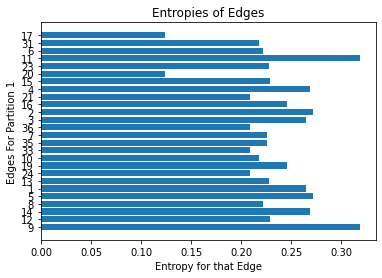

In [ ]:
#entropy of edges compared
y=list(Ent_Edge_Dict.keys()) 
x=list(Ent_Edge_Dict.values())
plt.barh(y,x)
plt.ylabel("Edges For Partition 1")
plt.xlabel("Entropy for that Edge")
plt.title("Entropies of Edges")
plt.show()



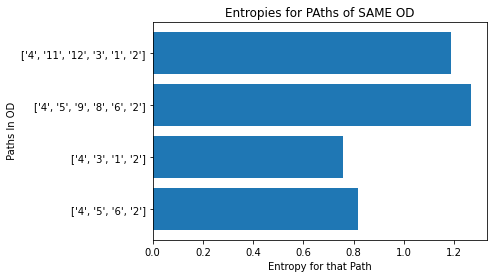

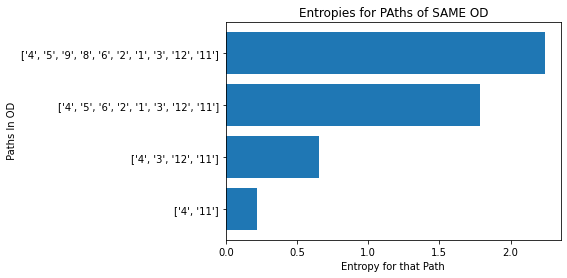

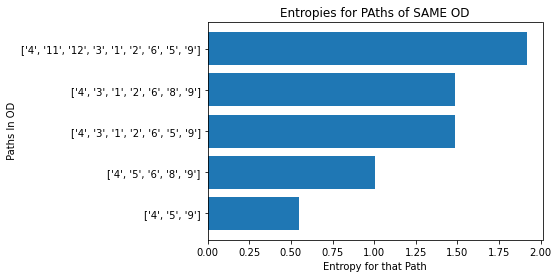

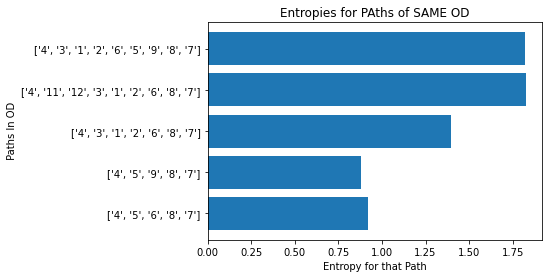

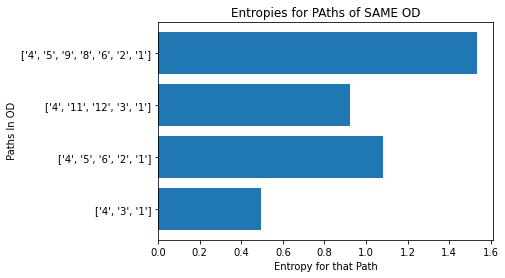

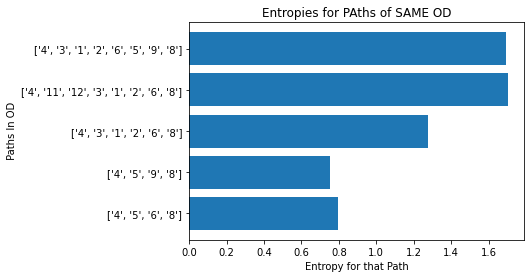

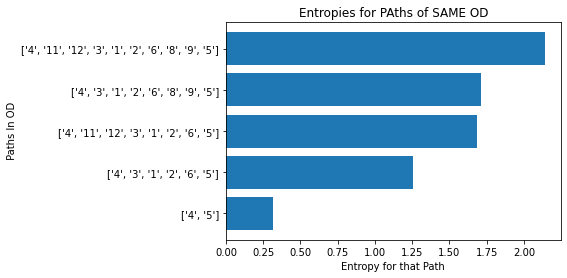

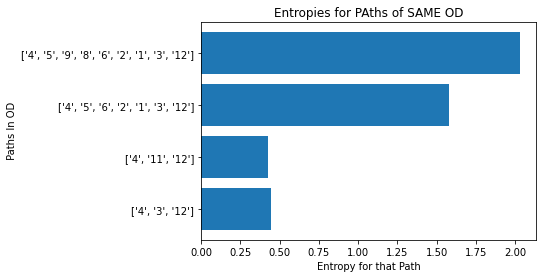

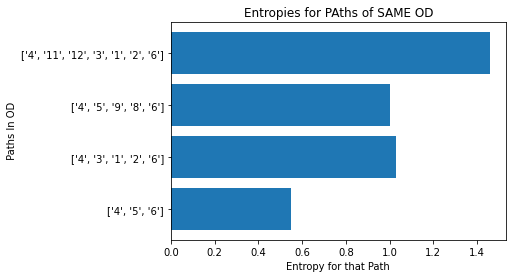

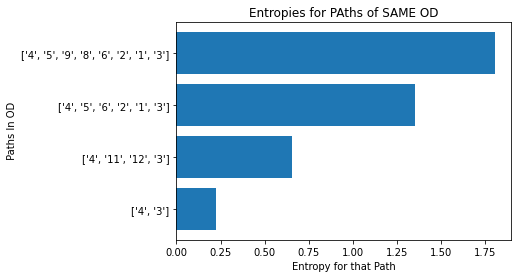

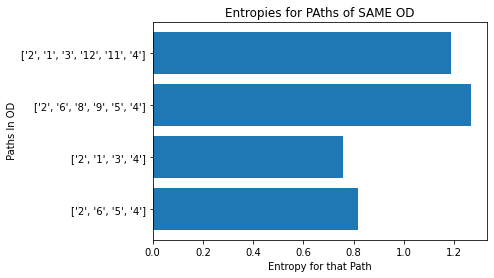

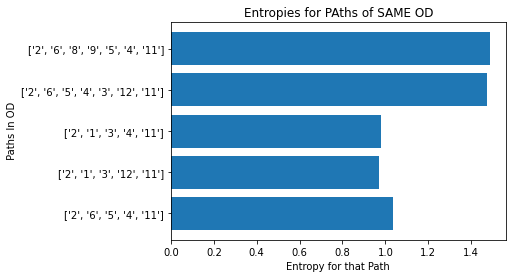

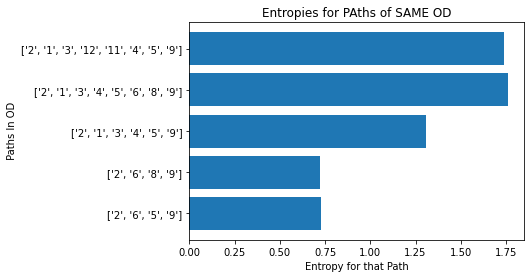

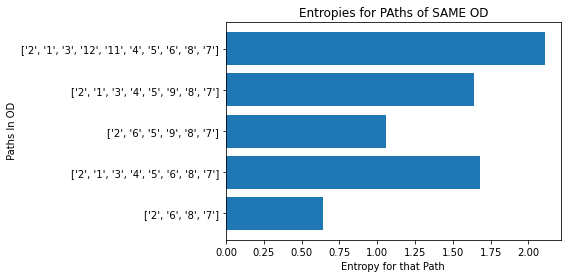

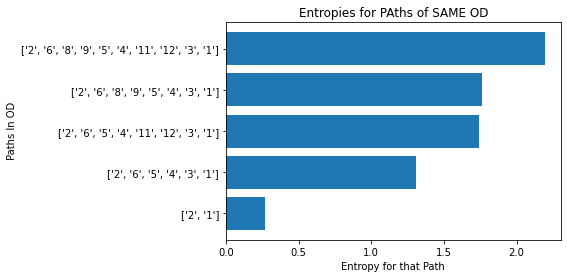

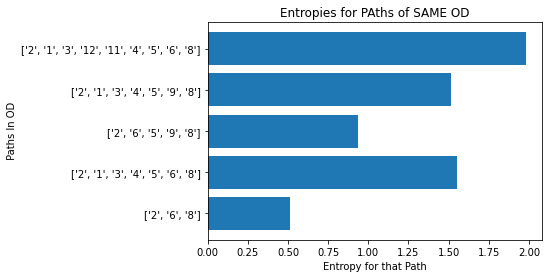

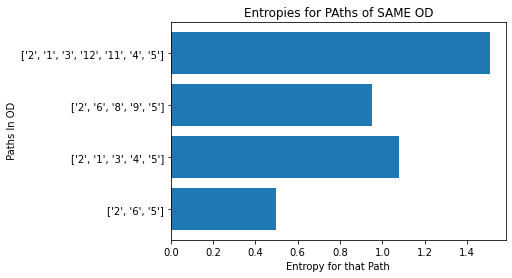

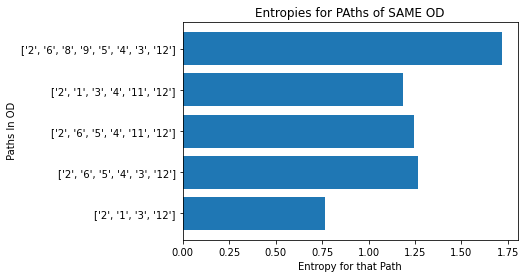

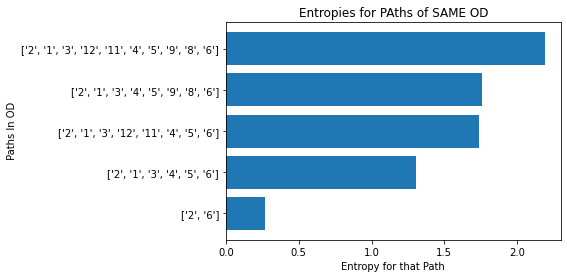

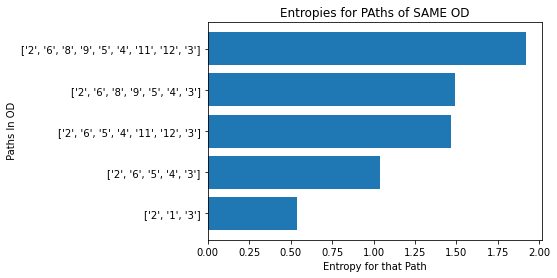

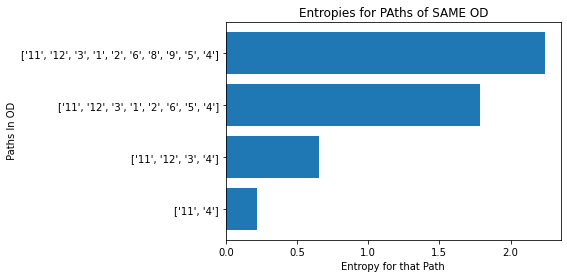

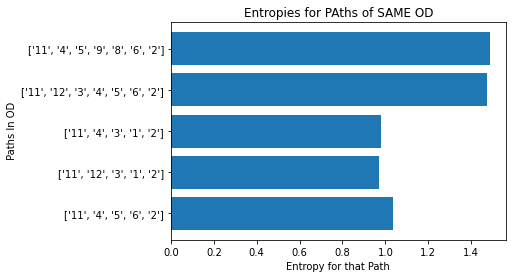

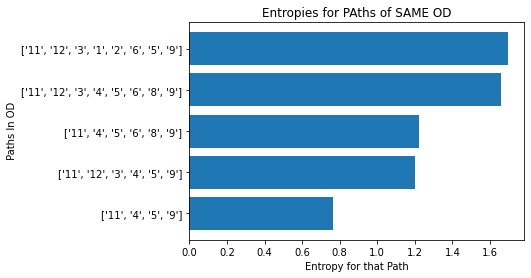

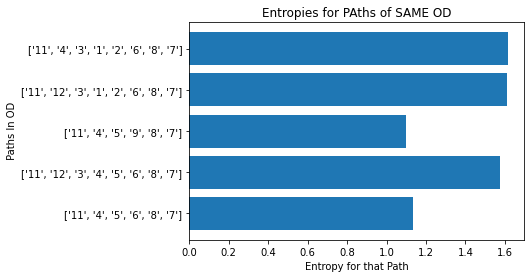

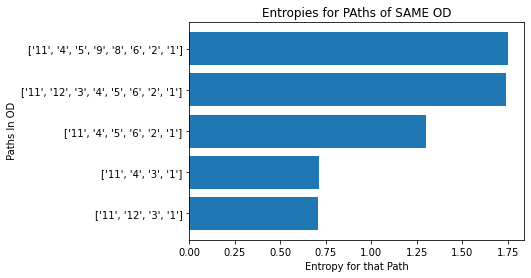

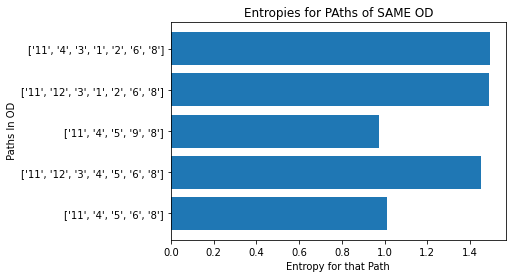

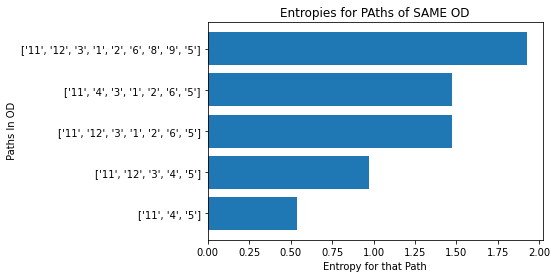

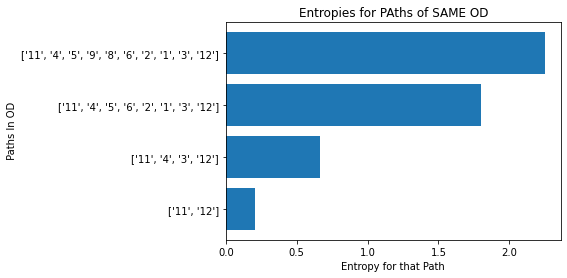

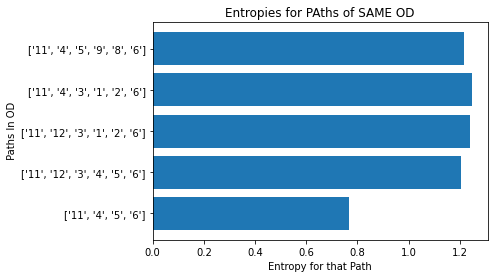

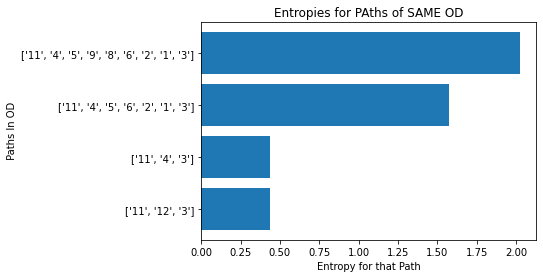

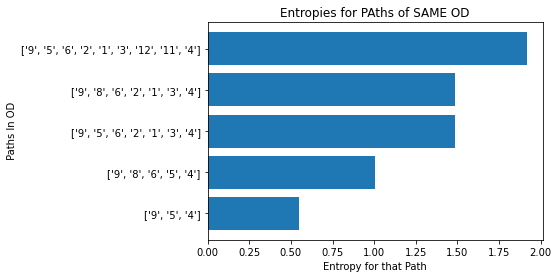

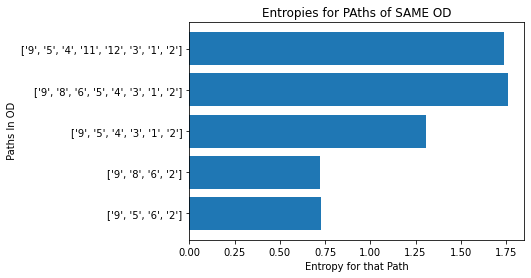

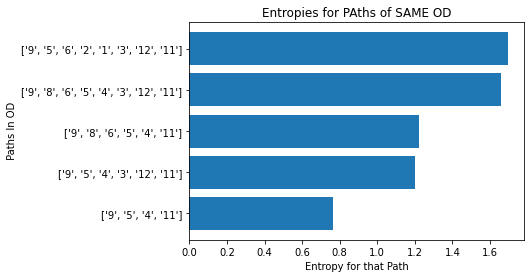

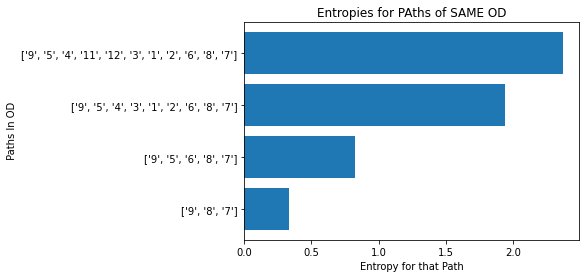

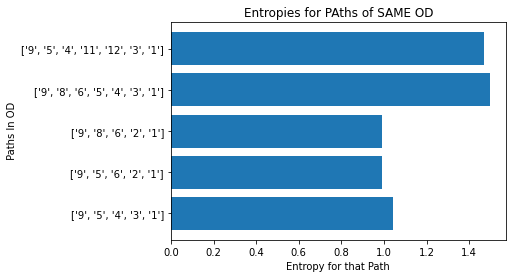

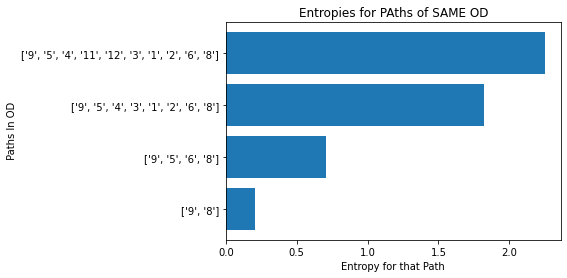

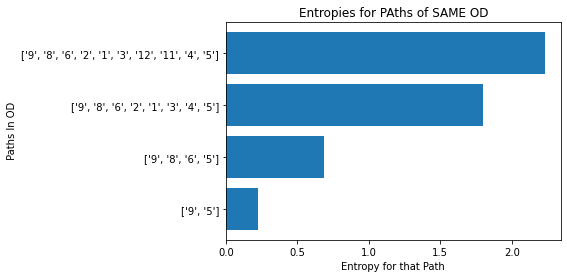

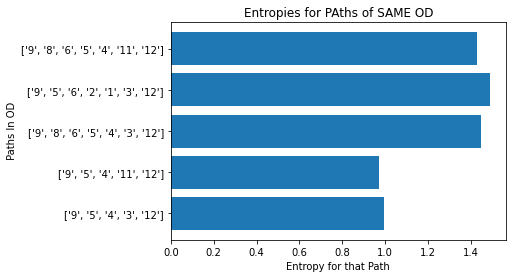

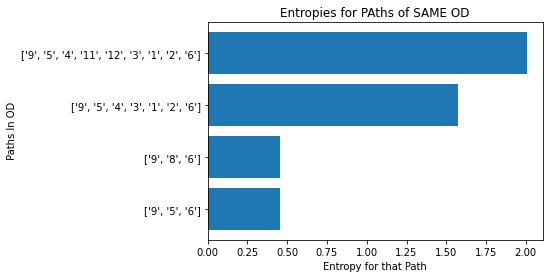

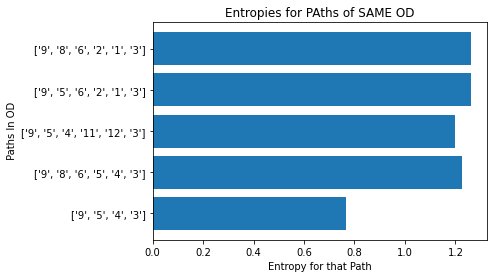

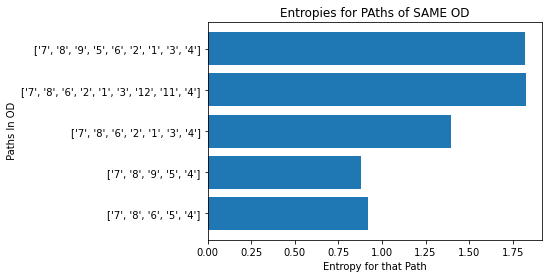

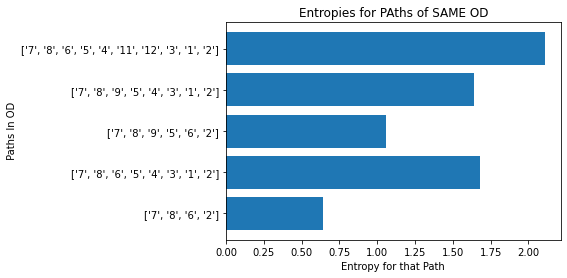

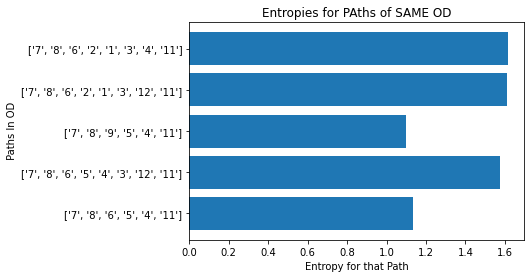

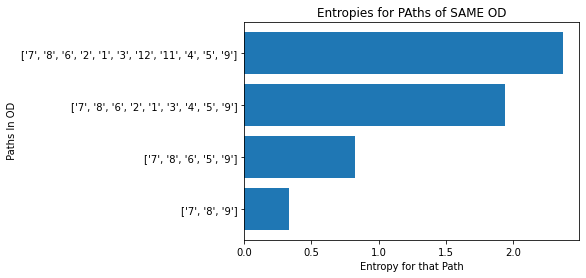

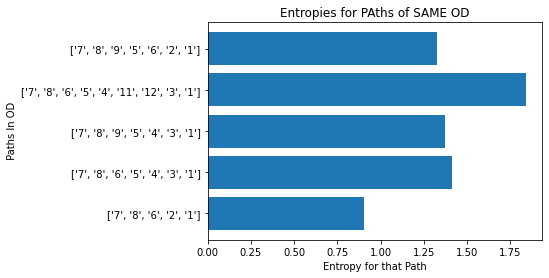

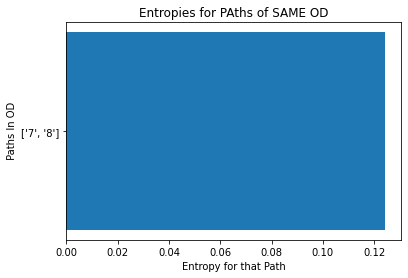

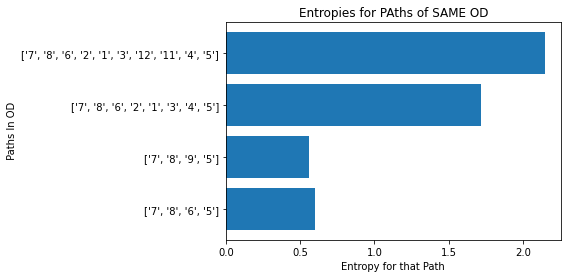

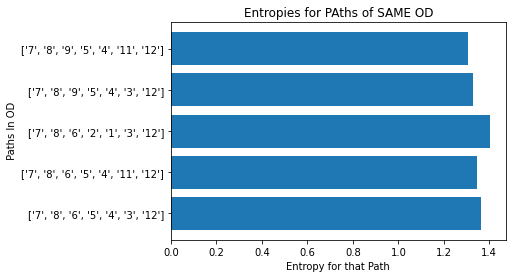

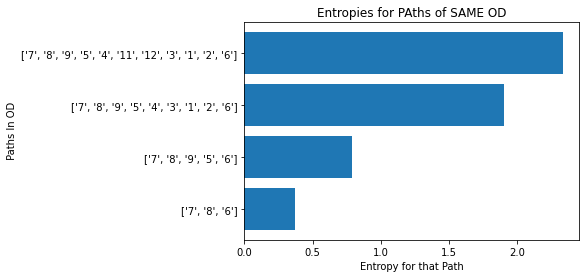

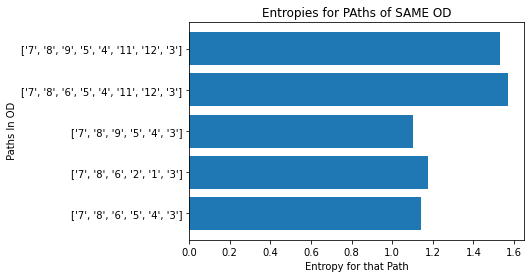

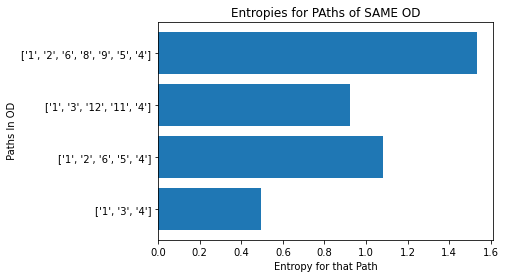

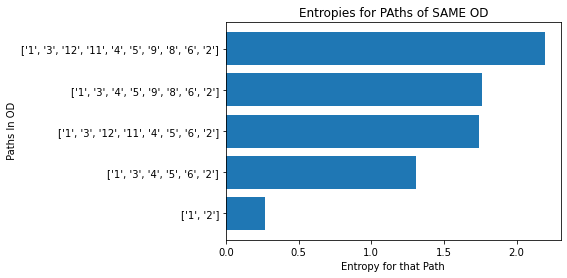

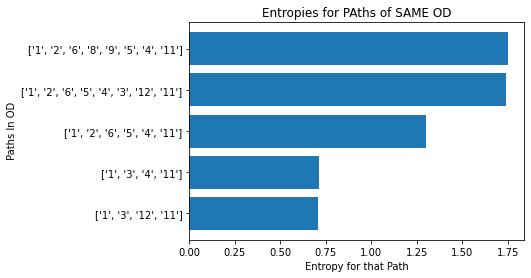

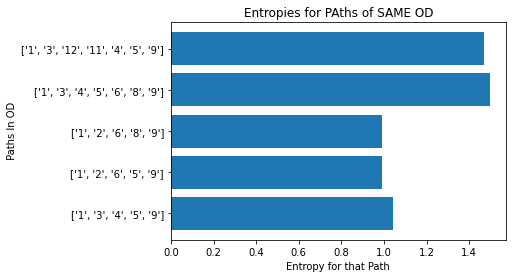

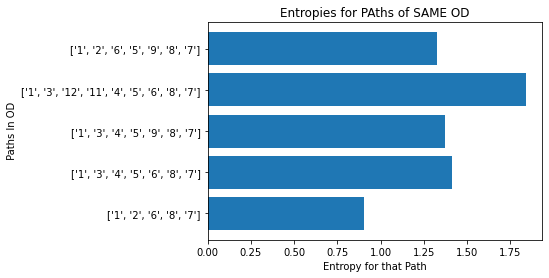

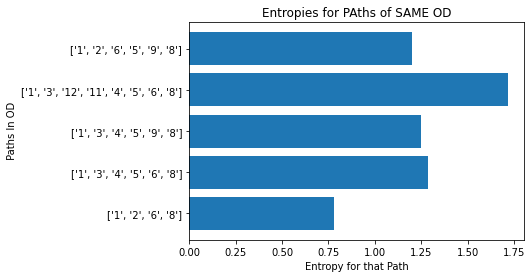

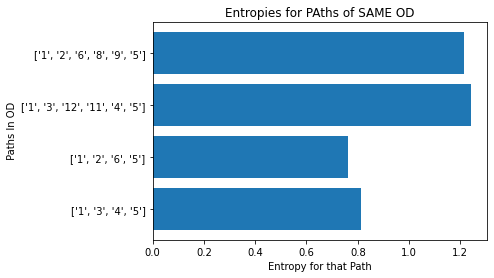

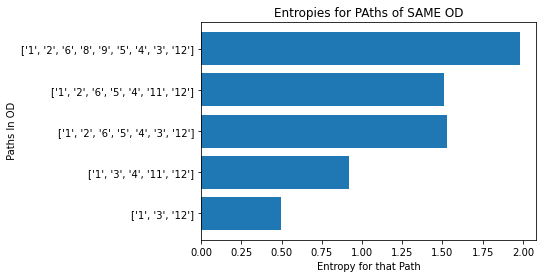

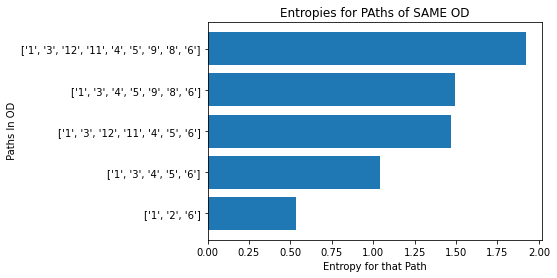

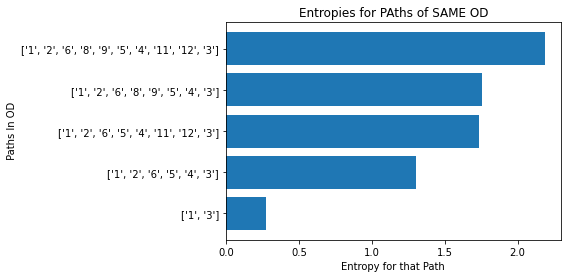

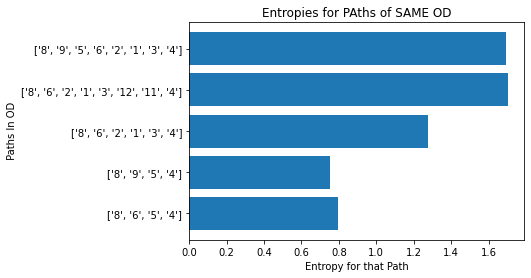

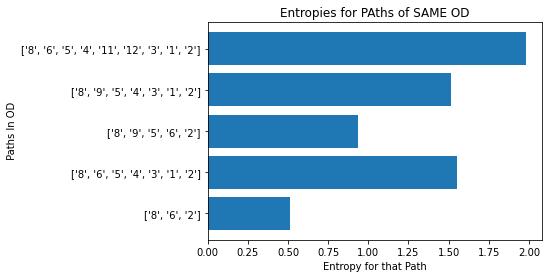

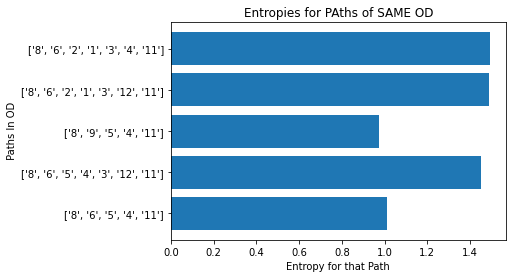

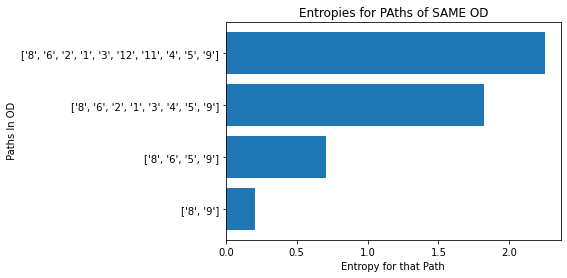

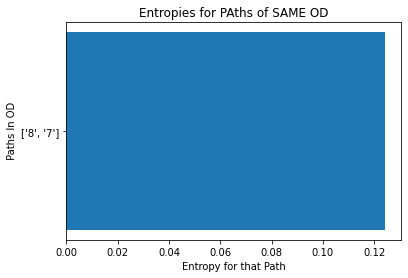

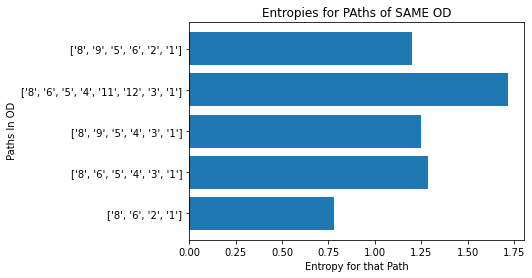

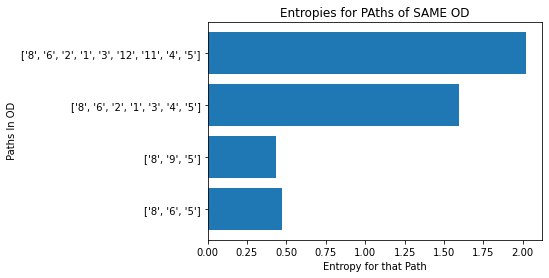

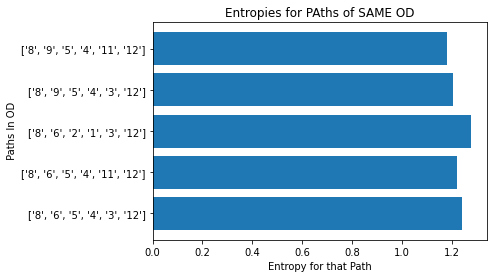

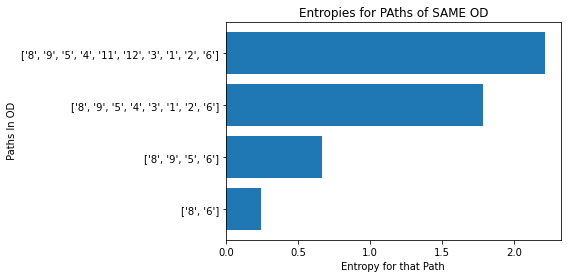

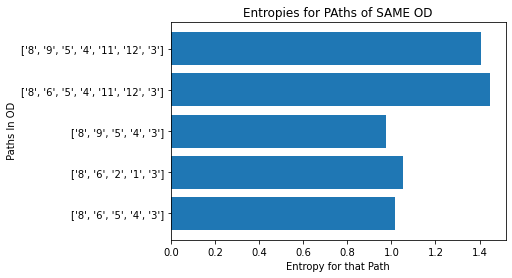

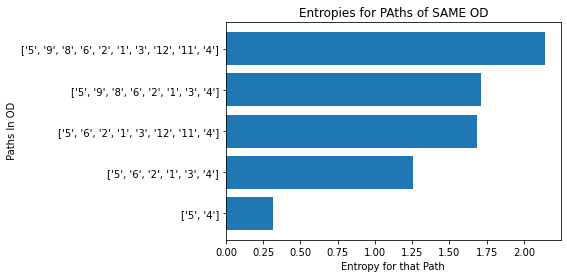

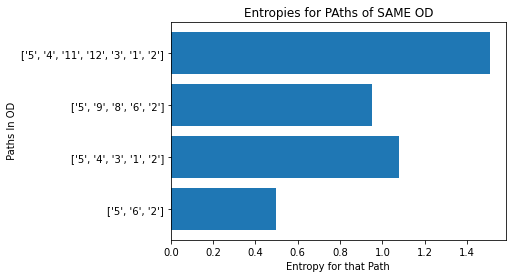

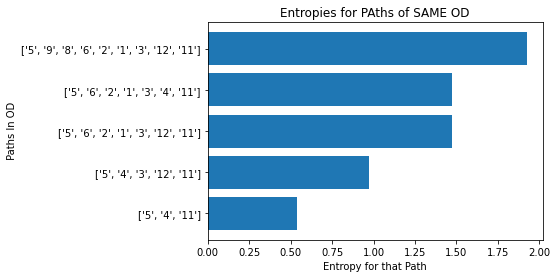

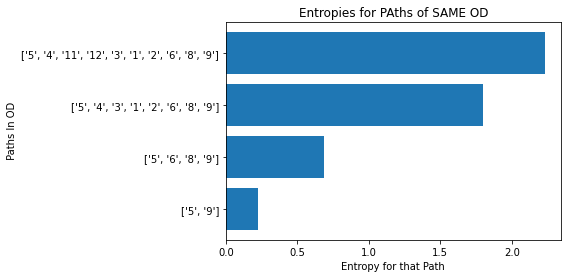

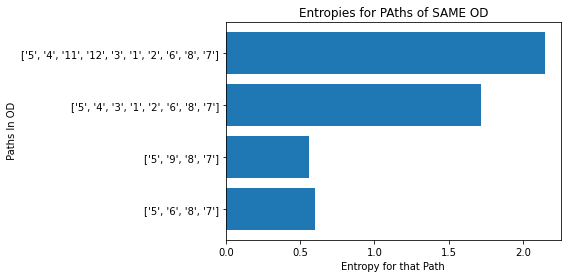

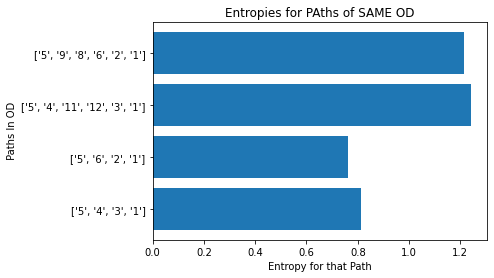

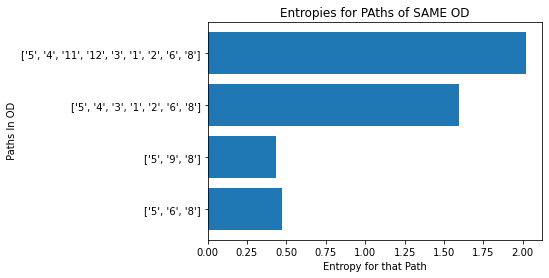

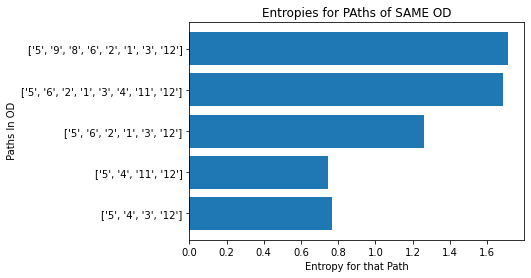

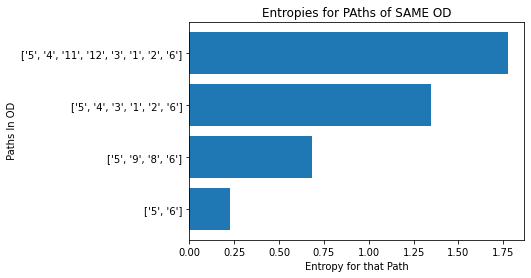

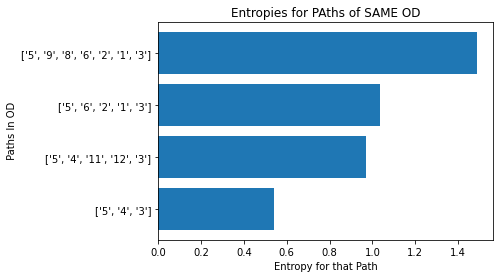

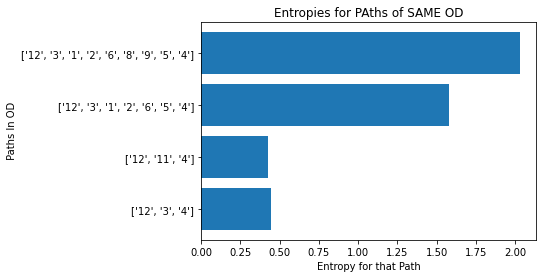

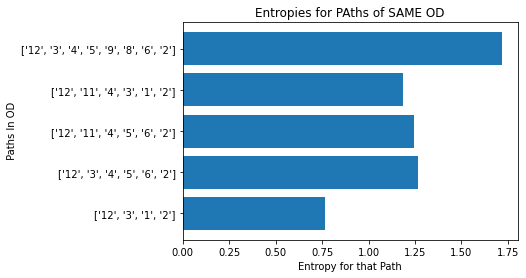

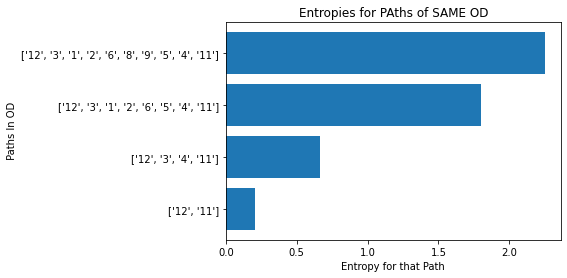

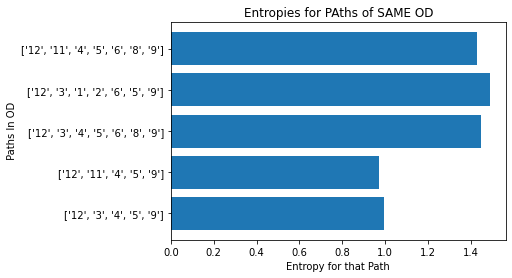

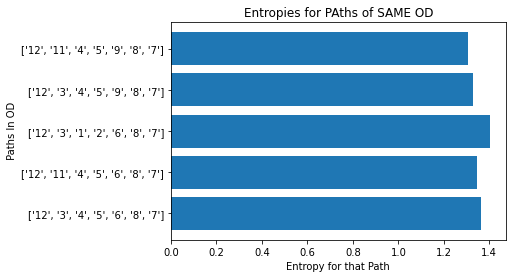

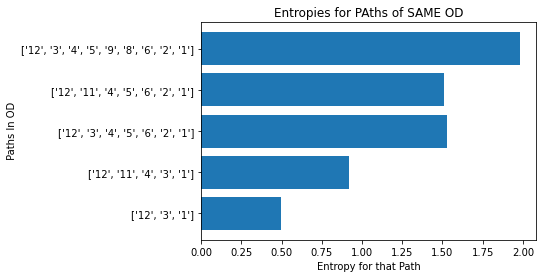

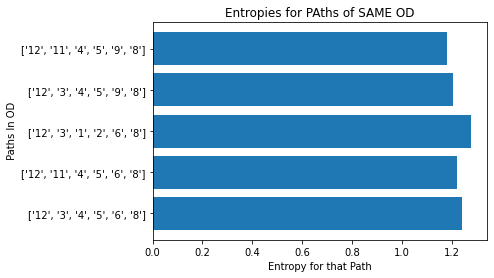

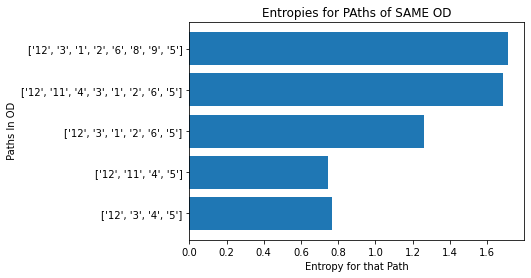

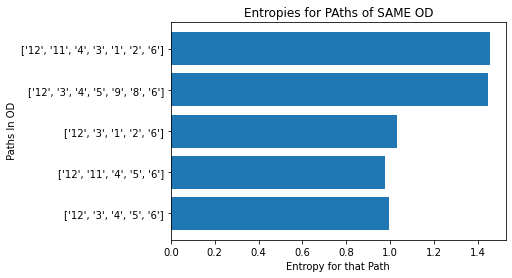

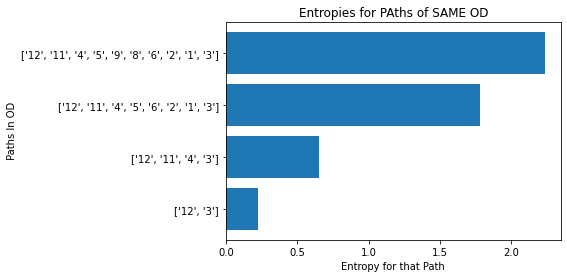

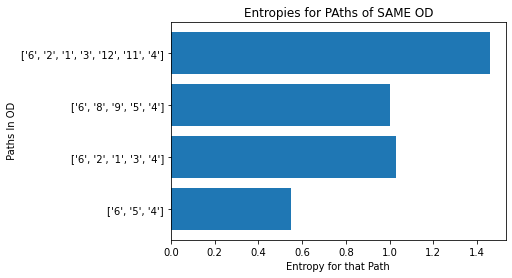

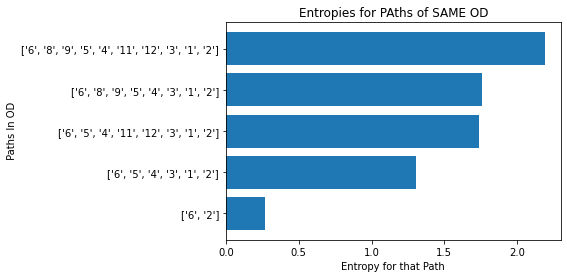

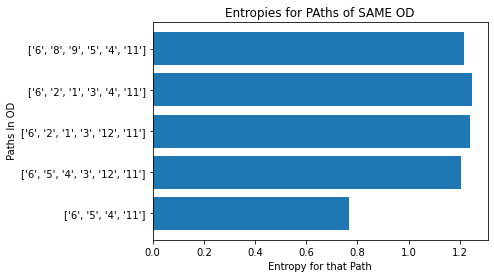

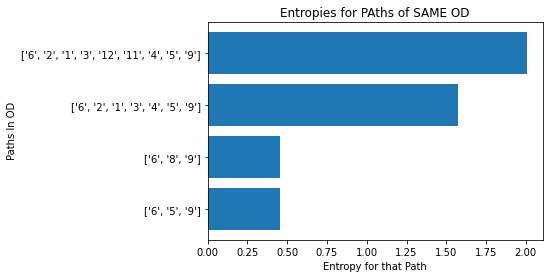

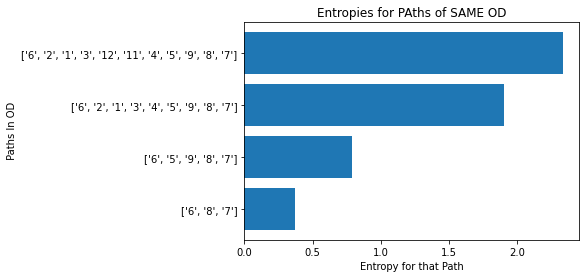

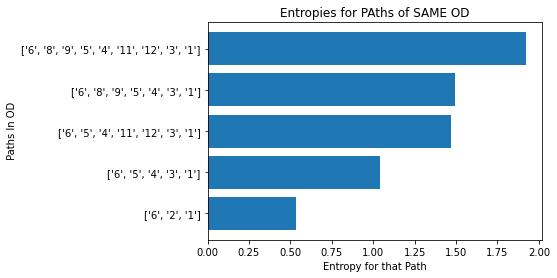

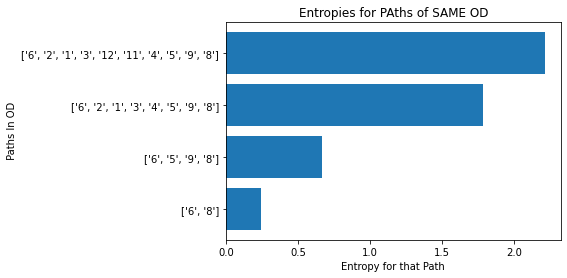

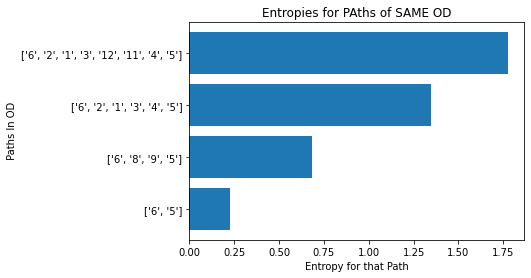

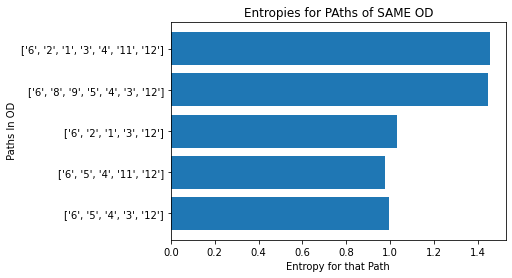

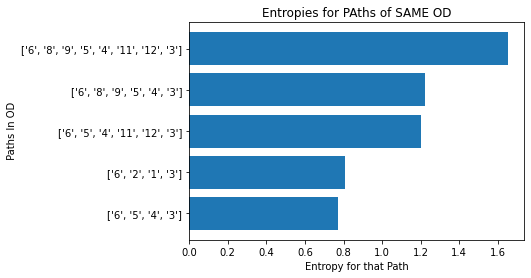

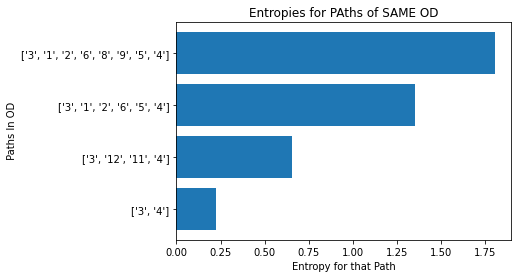

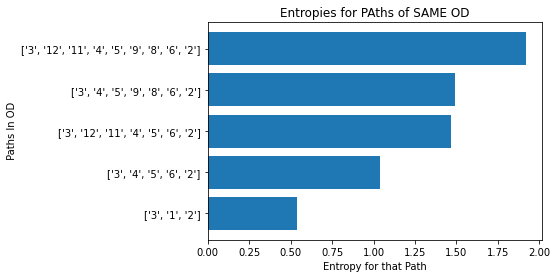

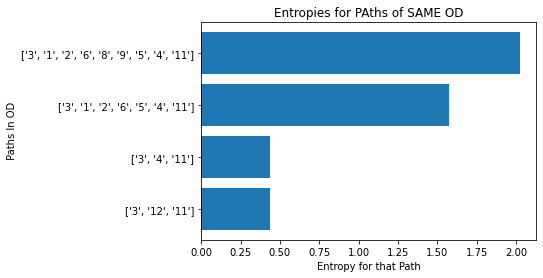

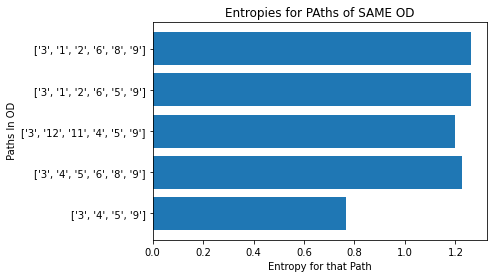

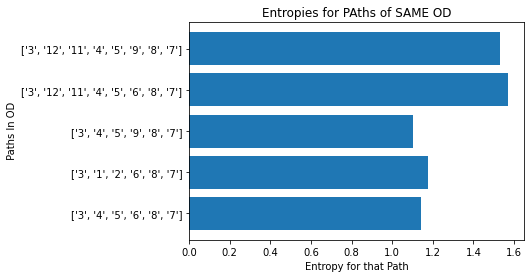

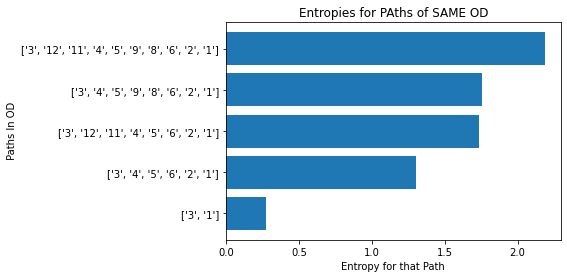

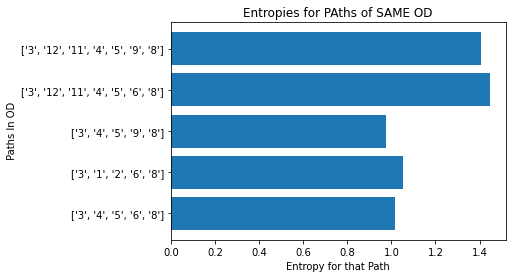

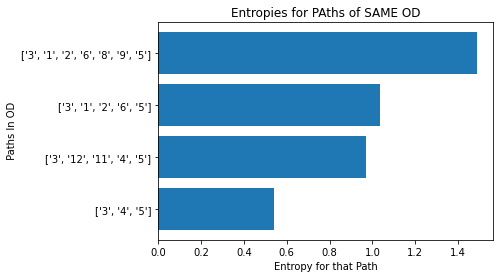

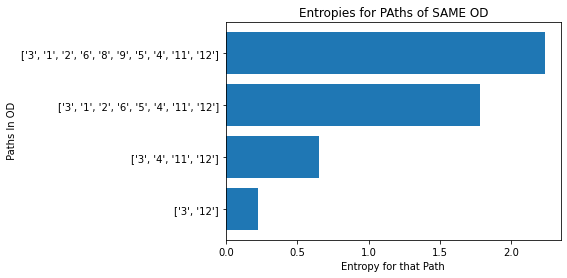

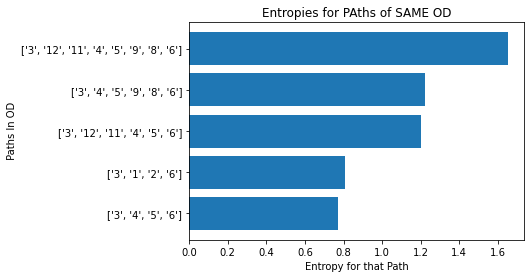

'        \ny=list(Ent_Path_Dict.keys()) \nx=list(Ent_Path_Dict.values())\nplt.barh(y,x)\nplt.ylabel("Edges For Partition 1")\nplt.xlabel("Entropy for that Edge")\nplt.title("Entropies of Edges")\nplt.show()\n'

In [ ]:
#print(list(Ent_Path_Dict.values())[0][0][0])
for i in list(Ent_Path_Dict.values()):
    lister=[]
    lister_two=[]
    for k in i:
        lister.append(str(k[0]))
        lister_two.append(k[1])
    y=lister
    x=lister_two 
    plt.barh(y,x)
    plt.ylabel(" Paths In OD")
    plt.xlabel("Entropy for that Path")
    plt.title("Entropies for PAths of SAME OD")
    plt.show()       
'''        
y=list(Ent_Path_Dict.keys()) 
x=list(Ent_Path_Dict.values())
plt.barh(y,x)
plt.ylabel("Edges For Partition 1")
plt.xlabel("Entropy for that Edge")
plt.title("Entropies of Edges")
plt.show()
'''

[09-10 20:23:38: INFO ] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[09-10 20:23:38: INFO ] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


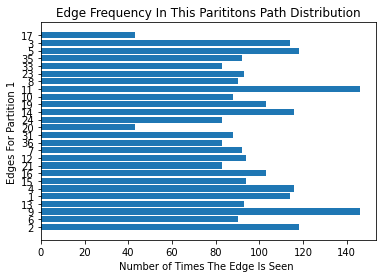

In [ ]:



    

y=list(grapher.keys())
x=list(grapher.values())
plt.barh(y,x)
plt.ylabel("Edges For Partition 1")
plt.xlabel("Number of Times The Edge Is Seen ")
plt.title("Edge Frequency In This Parititons Path Distribution")
plt.show()


[09-10 20:23:38: INFO ] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[09-10 20:23:38: INFO ] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


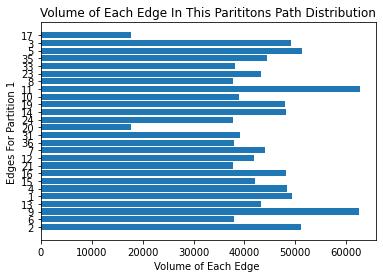

In [ ]:
y=list(volume_edges.keys())
x=list(volume_edges.values())
plt.barh(y,x)
plt.ylabel("Edges For Partition 1")
plt.xlabel("Volume of Each Edge ")
plt.title("Volume of Each Edge In This Parititons Path Distribution")
plt.show()

[09-10 20:23:39: INFO ] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[09-10 20:23:39: INFO ] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


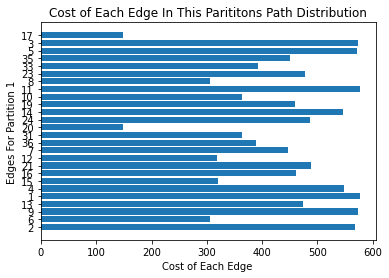

In [ ]:
y=list(cost_edges.keys())
x=list(cost_edges.values())
plt.barh(y,x)
plt.ylabel("Edges For Partition 1")
plt.xlabel("Cost of Each Edge ")
plt.title("Cost of Each Edge In This Parititons Path Distribution")
plt.show()

[09-10 20:23:39: INFO ] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[09-10 20:23:40: INFO ] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


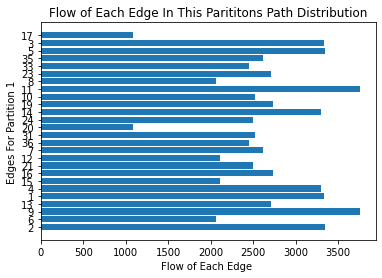

In [ ]:
y=list(flow_time.keys())
x=list(flow_time.values())
plt.barh(y,x)
plt.ylabel("Edges For Partition 1")
plt.xlabel("Flow of Each Edge ")
plt.title("Flow of Each Edge In This Parititons Path Distribution")
plt.show()

In [ ]:


#which edges are seen the most \
#bring coupling into play and try to assess which od are more coupled
def layer_five_new(paths_object):
    od_edge_counter=defaultdict(set)
    for i in paths_object:
        edges_list = [i for i in i.path_to_edges()]
        o=i.path[0]
        d=i.path[-1]
        od=o+'/'+d
        
        for edge in edges_list:
            
            od_edge_counter[od].add(edge)
   
    finalizer=defaultdict(list) 
    for i in od_edge_counter:
        for j in od_edge_counter:
            od=i
            od_2=j
            new_od_pair=od+'-'+od_2
            finalizer[new_od_pair].append(od_edge_counter[i].intersection(od_edge_counter[j]))
    return finalizer, od_edge_counter            
new_grapher, od_edge_counter= layer_five_new(paths_object)


keys = list(od_edge_counter.keys())
values = list(od_edge_counter.values())
new_list= list()
for i in values:
    new_list.append((list(i)))
#print(new_list)
#print(keys)
#print(new_list)
data={'OD': keys, 'Unique Edges' : new_list}

#####################df = pd.DataFrame(data)   #Ths is the one to run!!

#df=pd.DataFrame(data.data, columns=data.feature)

#firstOption
#display(df.to_string())


#secondOption
'''
with pd.option_context('display.max_rows', None,
                       'display.max_columns', None,
                       'display.precision', 3,
                       ):
    print(df)
    
'''



#thirdOption    
#print(df.to_markdown())

#heatMap
#print(df.corr())
#dataplot=sn.heatmap(data.corr())
#Keep thinking!

import plotly.graph_objects as go
fig = go.Figure()
for i in keys:
    for j in od_edge_counter[i]:


        fig.add_trace(go.Scatter(
            x=[i],
            y=[j],
            marker=dict(color="crimson", size=12),
            mode="markers",
            name="EdgesTaken",
        ))



fig.update_layout(title="OD Unique Edge Comparison",
                  xaxis_title="All Paths",
                  yaxis_title="All Unique Edges")

fig.show()     







                                    Path   Volume  Cost    Flow
0                        [1, 3, 4, 5, 9]  22500.0  15.0   500.0
1                        [1, 2, 6, 5, 9]  17200.0  20.0   500.0
2                        [1, 2, 6, 8, 9]  14400.0  23.0   500.0
3                  [1, 3, 4, 5, 6, 8, 9]  34300.0  26.0   500.0
4                [1, 3, 12, 11, 4, 5, 9]  29100.0  27.0   500.0
5                        [1, 2, 6, 8, 7]  17600.0  16.0   500.0
6                  [1, 3, 4, 5, 6, 8, 7]  37500.0  19.0   500.0
7                  [1, 3, 4, 5, 9, 8, 7]  28500.0  28.0   500.0
8          [1, 3, 12, 11, 4, 5, 6, 8, 7]  44100.0  31.0   500.0
9                  [1, 2, 6, 5, 9, 8, 7]  23200.0  33.0   500.0
10                                [1, 2]   1900.0   6.0   100.0
11                    [1, 3, 4, 5, 6, 2]  28400.0  19.0   100.0
12            [1, 3, 12, 11, 4, 5, 6, 2]  35000.0  31.0   100.0
13              [1, 3, 4, 5, 9, 8, 6, 2]  35000.0  32.0   100.0
14      [1, 3, 12, 11, 4, 5, 9, 8, 6, 2]

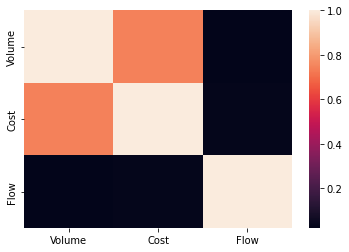

In [ ]:


path=list()
volume=list()
cost=list()
flow=list()
    
for i in holder.values():
    for j  in i:
        path.append((j[0]))
        volume.append(j[1])
        cost.append(j[2])
        flow.append(j[3])
        
data={'Path': path, 'Volume' : volume, 'Cost' : cost,  'Flow' : flow}

df = pd.DataFrame(data)

#df=pd.DataFrame(data.data, columns=data.feature)

#firstOption
#display(df.to_string())


#secondOption
with pd.option_context('display.max_rows', None,
                       'display.max_columns', None,
                       'display.precision', 3,
                       ):
    print(df)
    
print(df.corr(method='pearson'))

dataplot=sn.heatmap(df.corr())
  
# displaying heatmap
#dataplot.show()
        
